###### Note: Hyperparameter tuning is an extensive process, it may take 20-40 mins to execute the whole notebook.

# Forecasting the Selling Price of Used 2012 Cars: A Machine Learning Approach

#### Let's load some of the required libraries first

In [1]:
import sys
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

Also, we will load the dataset present in CSV file into a pandas DataFrame.

In [2]:
car_data = pd.read_csv("car_prices.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'car_prices.csv'

We will see how the data Looks like:

In [ ]:
car_data.head()

In [ ]:
car_data.info()

## Task 1:

### Observations:
1. Looking at the above data, there are 5 numerical columns : 'year', 'odometer', 'condition', 'mmr', and 'sellingprice'. The condition and mmr attributes are showing as an object type in the above description. I believe this is because there are some string values present in the data. We will remove those values from the dataset, in the data cleaning step.
2. There are 11 object data types, in which vin is a column with some encoded values. We will drop this column as I suppose that this column will do no harm to our model
3. Also, the saledate column contains the date time and timezone attributes. So, we need to process this attribute, and convert it into a date type using UTC = True(*converting to same timezone*)
4. Others are categorical values, which we will manage using ordinal encoder.

# Data Cleaning

As we are looking at the Used Car selling price data for the year 2012, we will only select data for the year 2012. 

In [ ]:
car_data = car_data[car_data['year'] == 2012]

And as the year column will be unique for every row and will not be further relevant, thus we will drop this column with the vin column

In [3]:
car_data.drop(columns= ['vin', 'year'], axis = 1, inplace = True)

NameError: name 'car_data' is not defined

Also, we will procees the saledate column

In [4]:
car_data['saledate'] = pd.to_datetime(car_data['saledate'], errors='coerce')
car_data['saledate'] = pd.to_datetime(car_data['saledate'],  utc=True).dt.date

NameError: name 'car_data' is not defined

Also, we will remove the string attributes present in condition and mmr column

In [8]:
car_data[['condition']] = car_data[['condition']].apply(pd.to_numeric, errors='coerce')
car_data[['mmr']] = car_data[['mmr']].apply(pd.to_numeric, errors='coerce')

##### Let's see what is the percentage of data in the Dataframe is null. The most null values are present in 'transmission' column.

In [9]:
print('Percentage of data that is null : {:,.2f}%'.format((max(car_data.isnull().sum())/len(car_data))*100))

Percentage of data that is null : 13.26%


If we apply dropna() directly on the data then about 13.26% data will get imputed. Instead of this, we can update transmission column with the most frequent value. 

In [10]:
from sklearn.impute import SimpleImputer
transmission_imputer = SimpleImputer(strategy='most_frequent')
car_data['transmission'] = transmission_imputer.fit_transform(car_data['transmission'].values.reshape(-1,1))

Now, lets see how much percent of data is null

In [11]:
print('Percentage of data that is null : {:,.2f}%'.format((max(car_data.isnull().sum())/len(car_data))*100))

Percentage of data that is null : 1.05%


I belive we can ignore 1.05% null data. Thus, We will remove all the rows from the DataFrame columns, which containes null values. 

In [12]:
car_data = car_data.dropna(subset = ['make','model','trim',
                                     'body','transmission',
                                     'state','condition',
                                     'odometer','color','interior',
                                     'seller','mmr','sellingprice', 'saledate'])

#### Let's validate if the data cleaning is successful or not

In [13]:
car_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100612 entries, 744 to 558834
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   make          100612 non-null  object 
 1   model         100612 non-null  object 
 2   trim          100612 non-null  object 
 3   body          100612 non-null  object 
 4   transmission  100612 non-null  object 
 5   state         100612 non-null  object 
 6   condition     100612 non-null  float64
 7   odometer      100612 non-null  float64
 8   color         100612 non-null  object 
 9   interior      100612 non-null  object 
 10  seller        100612 non-null  object 
 11  mmr           100612 non-null  int64  
 12  sellingprice  100612 non-null  int64  
 13  saledate      100612 non-null  object 
dtypes: float64(2), int64(2), object(10)
memory usage: 11.5+ MB


In [14]:
car_data.isnull().sum()

make            0
model           0
trim            0
body            0
transmission    0
state           0
condition       0
odometer        0
color           0
interior        0
seller          0
mmr             0
sellingprice    0
saledate        0
dtype: int64

Looking at the above information, I believe that the data cleaning is successful. We will take one final look at the data.

In [15]:
car_data.head()

,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
744,BMW,6 Series,650i,Convertible,automatic,ca,3.8,28925.0,white,black,financial services remarketing (lease),48500,50500,2014-12-18
745,Acura,TSX,Base,Sedan,automatic,ca,3.9,43127.0,black,black,"ahfc/honda lease trust/hvt, inc. eot",16450,17800,2014-12-18
746,BMW,6 Series,650i,Convertible,automatic,ca,4.6,16381.0,gray,black,financial services remarketing (lease),48200,46500,2015-02-11
748,Audi,A6,3.0T Premium quattro,Sedan,automatic,ca,3.5,36541.0,—,beige,high bid trading co inc,29800,29000,2014-12-18
749,BMW,6 Series,650i,Coupe,automatic,ca,4.7,34941.0,black,black,financial services remarketing (lease),42600,42500,2014-12-18


#####  Summarize the data. How much data is present? What attributes/features are continuous valued? Which attributes are categorical?

## Observations:
1. Amount of the Data Present before data cleaning(No. of Rows) : 558837 
2. Amount of the Data Present after data cleaning(No. of Rows) : 100612 
3. Features : make, model, trim, body, transmission, state, condition, odometer, color, interior, seller, mmr, saledate
4. Number of features : 14
5. Label : 'sellingprice'
6. Categorical features : make, model, trim, body, transmission, state, color, interior,
7. Features cotaining descrete integer values : mmr, sellingprice
8. Features cotaining continuous values : condition, odometer

## Task 2:  

##### Display  the  statistical  values  for  each  of  the  attributes,  along  with  visualizations  of  the  distributions  for  each  attribute.

In [16]:
car_data.describe(include='all')

,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
count,100612,100612,100612,100612,100612,100612,100612.000000,100612.000000,100612,100612,100612,100612.000000,100612.000000,100612
unique,39,305,418,60,2,38,NaN,NaN,19,17,4490,NaN,NaN,154
top,Nissan,Altima,Base,Sedan,automatic,pa,NaN,NaN,black,black,nissan-infiniti lt,NaN,NaN,2015-01-13
freq,16835,8341,9192,42432,98463,15719,NaN,NaN,23829,50251,12445,NaN,NaN,3193
mean,NaN,NaN,NaN,NaN,NaN,NaN,3.680888,42510.512235,NaN,NaN,NaN,16721.354560,16590.332644,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,0.781255,22373.949718,NaN,NaN,NaN,8018.764673,8088.086722,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,NaN,NaN,NaN,1950.000000,400.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,3.200000,28278.000000,NaN,NaN,NaN,11300.000000,11100.000000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,3.800000,37460.000000,NaN,NaN,NaN,14250.000000,14300.000000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,4.300000,52384.250000,NaN,NaN,NaN,20600.000000,20400.000000,NaN


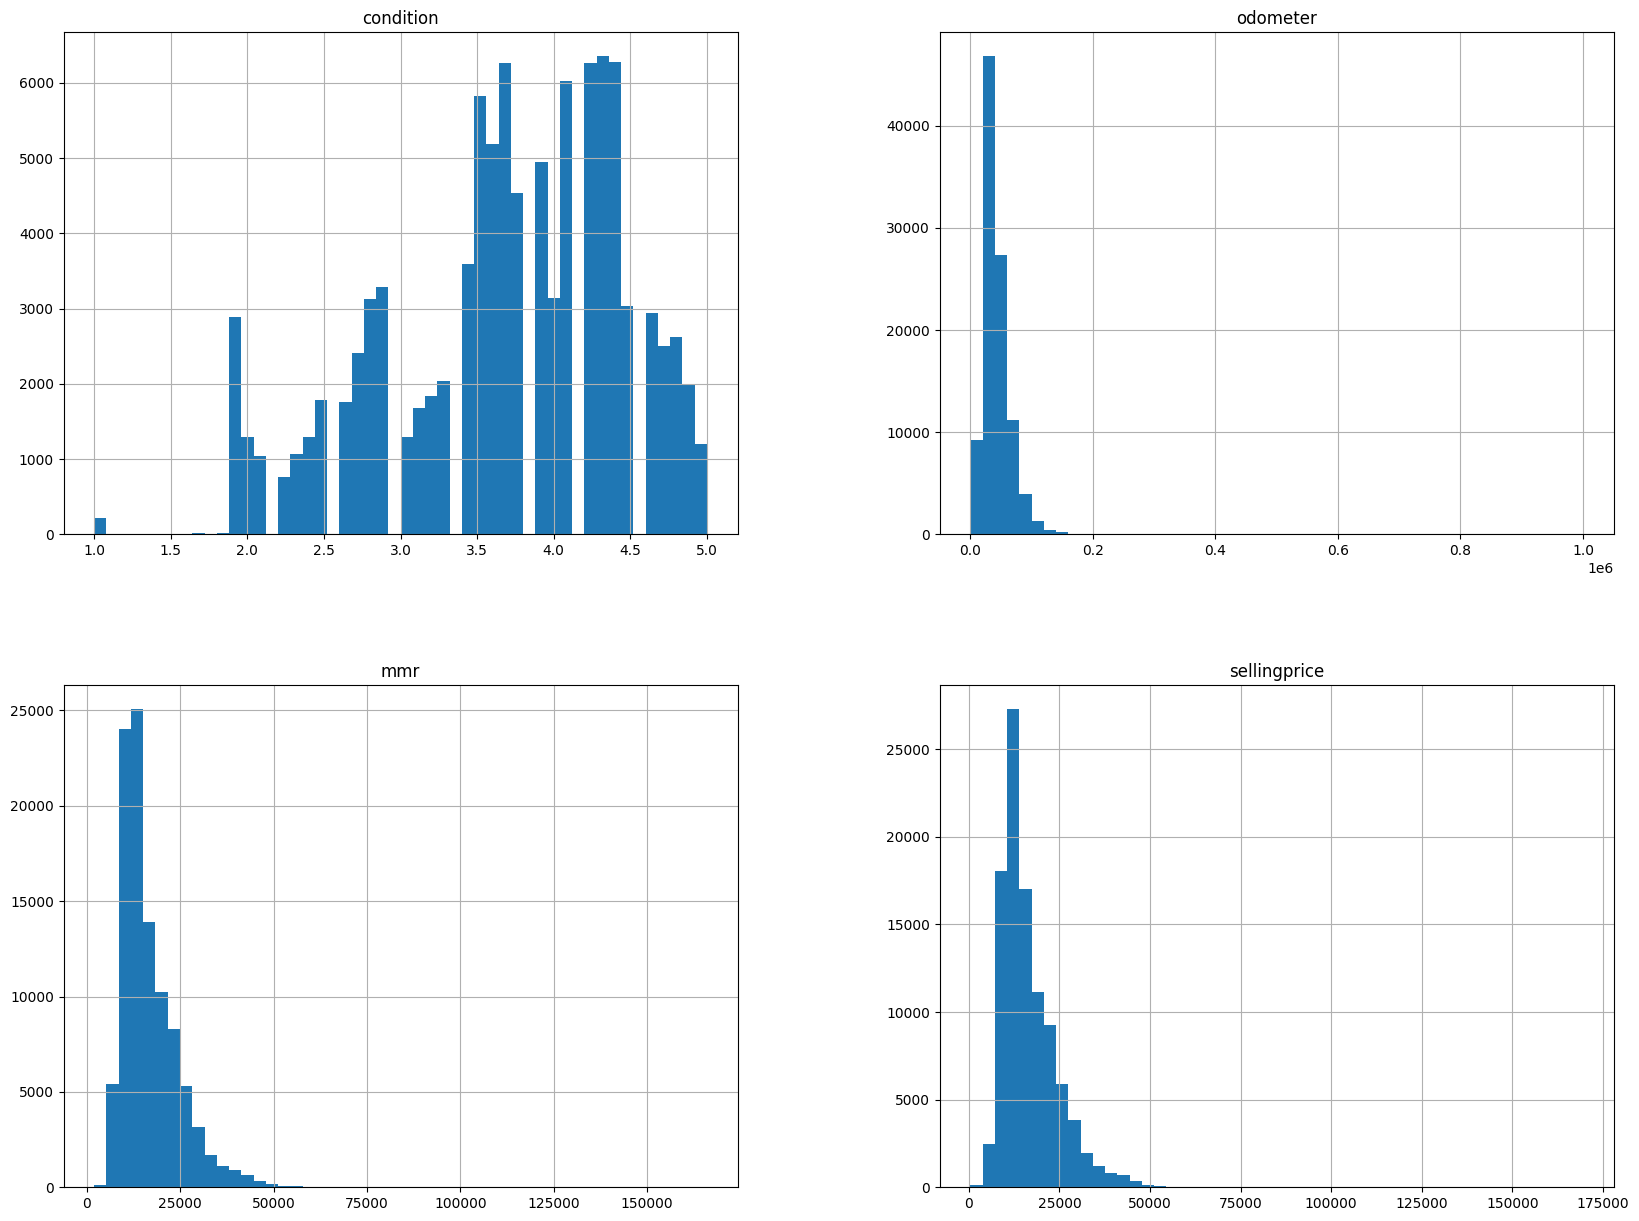

In [17]:
car_data.hist(bins = 50, figsize=(20,15))
plt.show()

#### Let's plot the distribution and see the values.

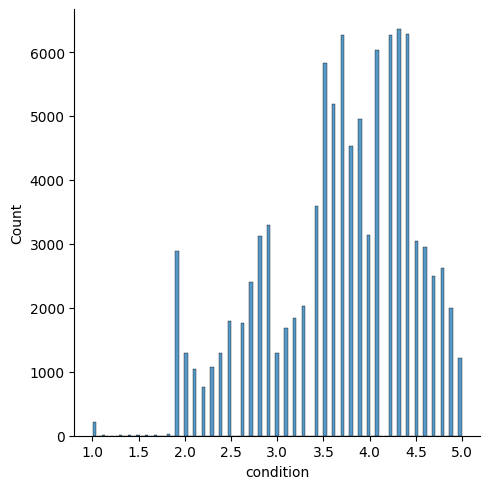

In [18]:
sns.displot(car_data, x="condition", shrink=.8)

#### Observations:  
1. Majority of cars have their condition ratings from 3.5 to 4.5, 1 being worst and 5 being best.
2. Around 7000 cars have rating 1.0 but there are not much cars with ratings froom 1.11 to 1.8 and suddenly at rating 1.9, there is staggering 40000 cats. After that, the distribution of ratings is somewhat reasonable.
3. There around 10000 cars who are in the best shape.

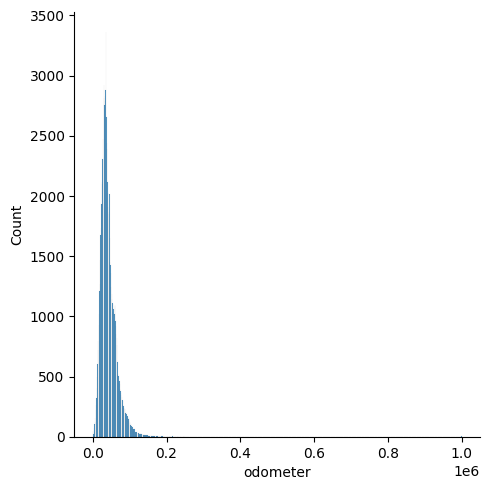

In [19]:
sns.displot(car_data, x="odometer", shrink=.8)

#### Observations:  
1. Most of the cars have their odometer range in between 40000 to 60000, where the 50145 is median value. The data is rightly skewed

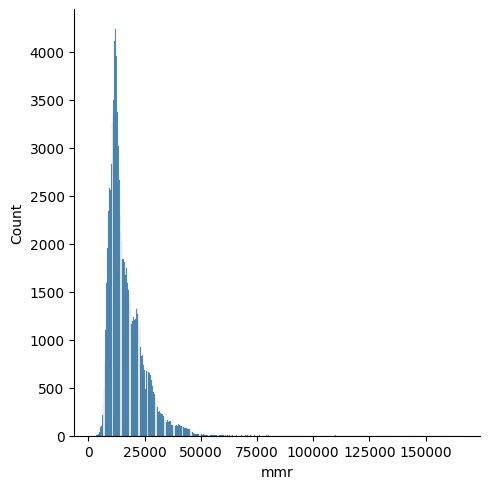

In [20]:
sns.displot(car_data, x="mmr", shrink=.8)

#### Observations:  
1. The data is rightly skewed
2. Most of the cars have MMR values ranging from 10000 to 15000, and 12500 being the mean.

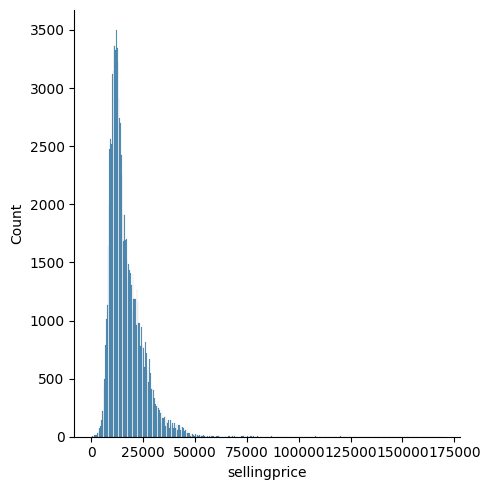

In [21]:
sns.displot(car_data, x="sellingprice", shrink=.8)

#### Observations:  
1. Most of the used cars have averrage selling price of \$12400. 

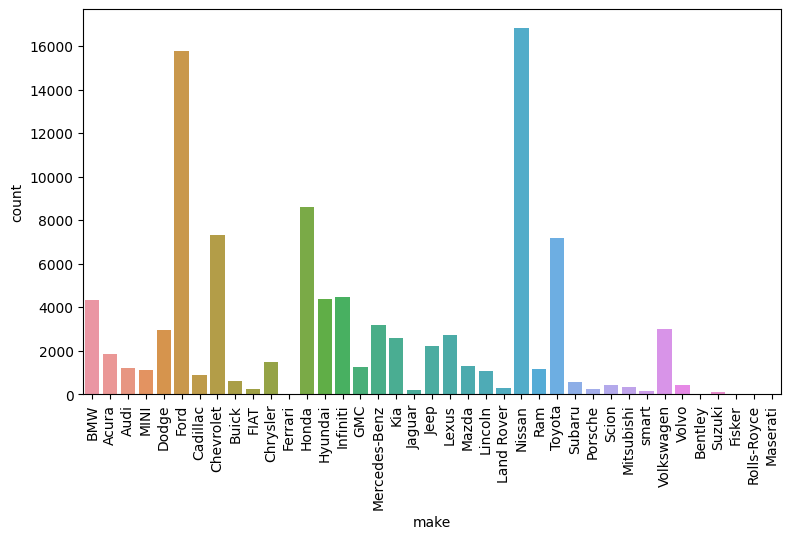

In [22]:
plt.figure(figsize=(9,5))
chart = sns.countplot(x='make',data=car_data)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.show()

#### Observations:  
1. Nissan and Ford models produced in 2012 are popular buying choices among the used cars 

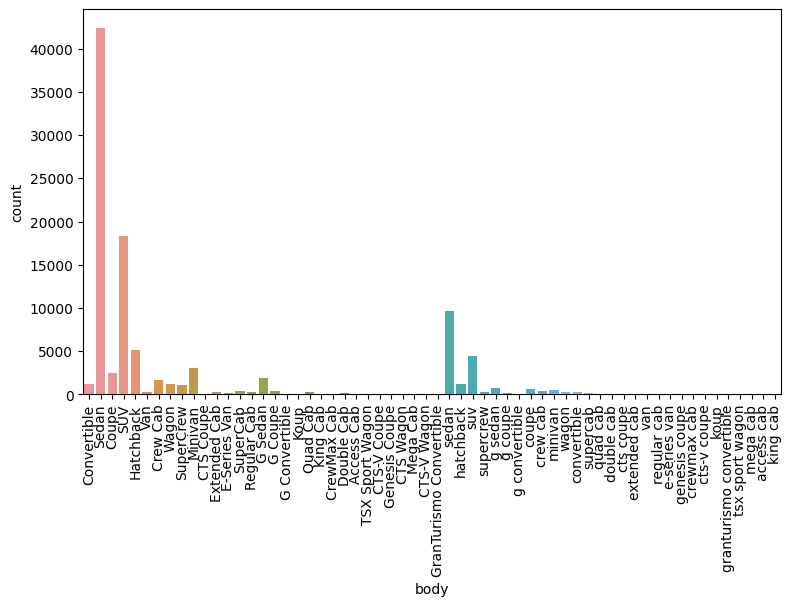

In [23]:
plt.figure(figsize=(9,5))
chart = sns.countplot(x='body',data=car_data)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.show()

#### Observations:  
1. It looks like most of the people prefer buying a Sedan and SUV more than other car types.

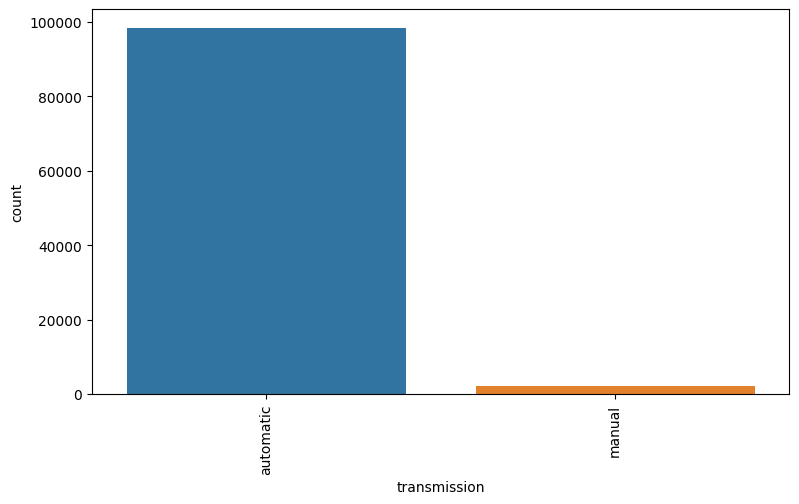

In [24]:
plt.figure(figsize=(9,5))
chart = sns.countplot(x='transmission',data=car_data)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.show()

#### Observations:  
1. It looks like most of the cars produced in 2012 have automatic transmission and just a few have manual transmission.

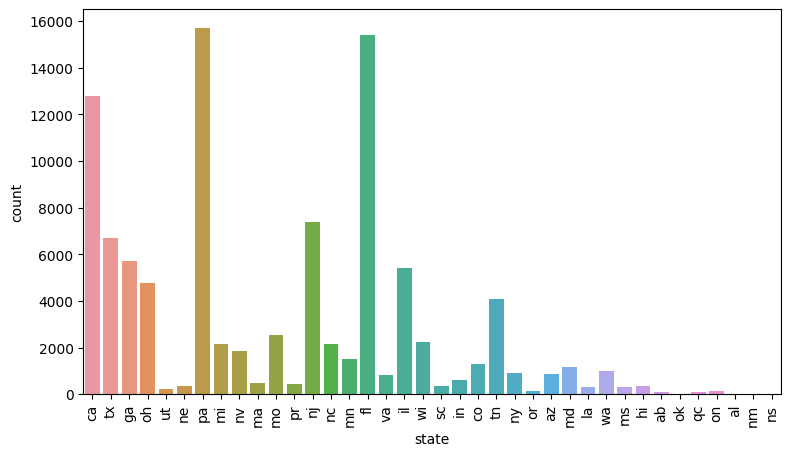

In [25]:
plt.figure(figsize=(9,5))
chart = sns.countplot(x='state',data=car_data)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.show()

#### Observations:  
1. Pennsylvania, Florida, California have quite big used car market

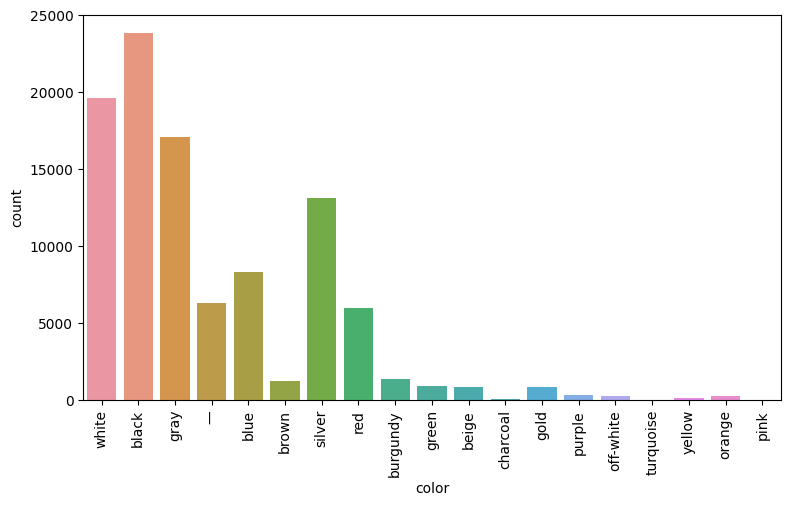

In [26]:
plt.figure(figsize=(9,5))
chart = sns.countplot(x='color',data=car_data)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.show()

#### Observations:  
1. Most of the buyers preferred black, white, grey and silver color for exterior body of the cars produced in 2012.

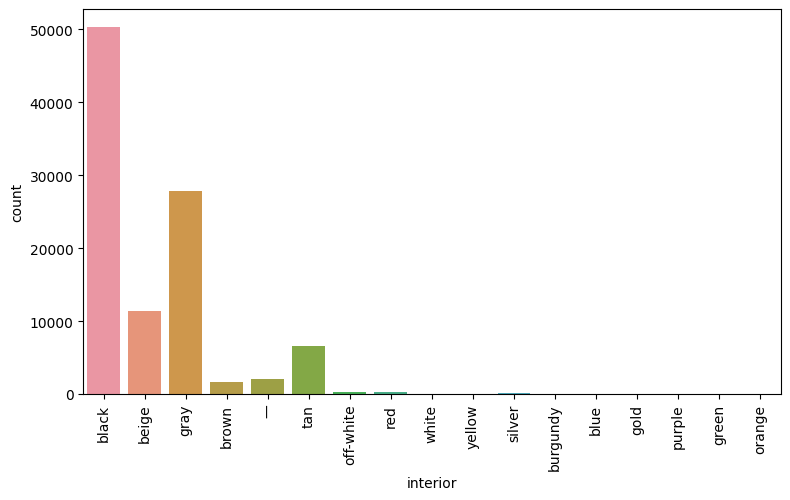

In [27]:
plt.figure(figsize=(9,5))
chart = sns.countplot(x='interior',data=car_data)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.show()

#### Observations:  
1. Although there are few favorite choices for exterior of the car, For interior, the most favorite choices are limited to the black and grey colors.

### Treatments Required : 
1. As the make, model, trim, body, transmission, state, color, interior, and saledate columns contains categorical values, first of call converting all values in the same case is necessary to avoid duplicate values, so first I will tune the values into lowercase and then I will encode these values using ordinal encoder.

## Task3:

#### Analyze and discuss the relationships between the data attributes, and between the data attributes  and  label. 

In [28]:
car_data.corr(method ='pearson')

,condition,odometer,mmr,sellingprice
condition,1.000000,-0.185553,0.195689,0.281308
odometer,-0.185553,1.000000,-0.241136,-0.250719
mmr,0.195689,-0.241136,1.000000,0.979752
sellingprice,0.281308,-0.250719,0.979752,1.000000


In [29]:
car_data.corr(method ='pearson')["sellingprice"].sort_values(ascending=False)

sellingprice    1.000000
mmr             0.979752
condition       0.281308
odometer       -0.250719
Name: sellingprice, dtype: float64

It looks like the selling price is heavily dependant on the MMR, with positive correlation and the odometer has the negative correlation.

Let's visualize the pairplots to understand the correlation

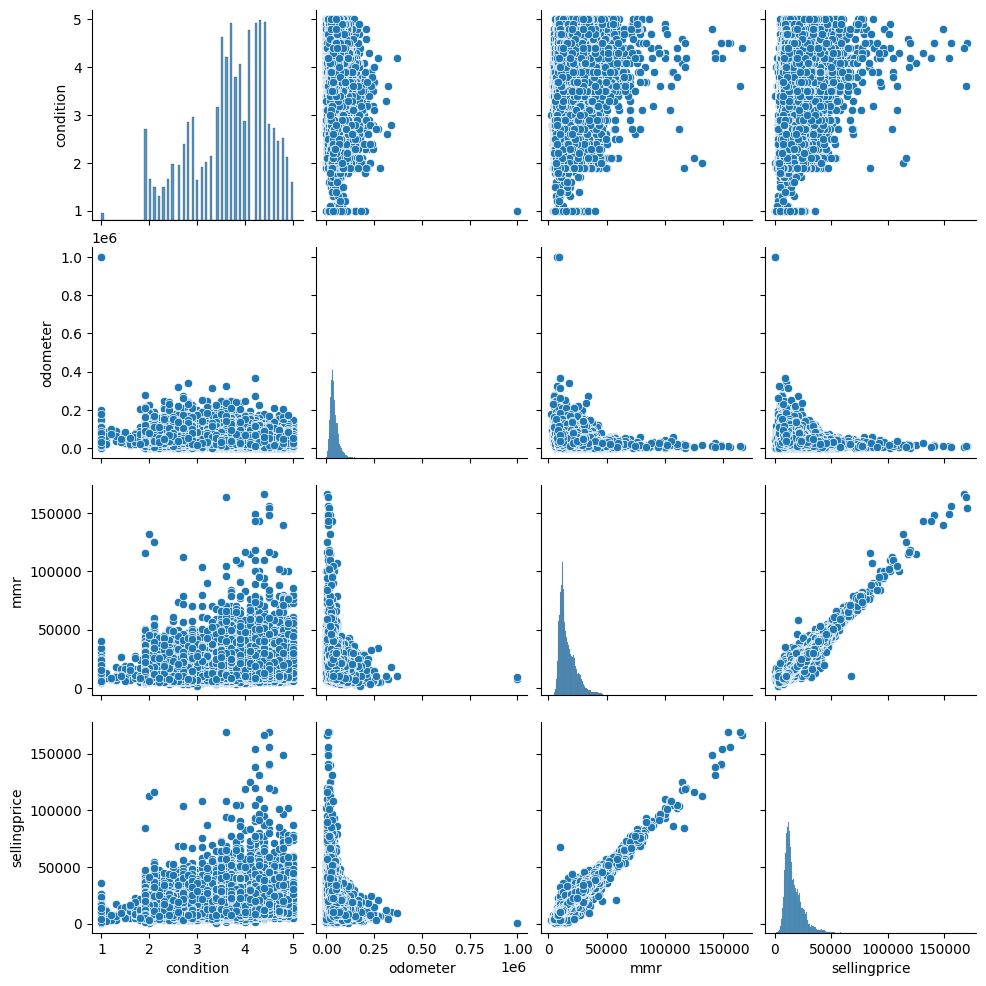

In [30]:
sns.pairplot(car_data)

#### Observations:  
1. From pairplot, we can infer that there is strong positive correlation between selling price and MMR

### The relationship between data attributes and label :

In the above graph, we explored the relationship between the attributes. Now, going forward we will plot scatter plot for all the attributes against the label. In this case, 'sellingprice'.

##### Relationship between sellingprice and MMR

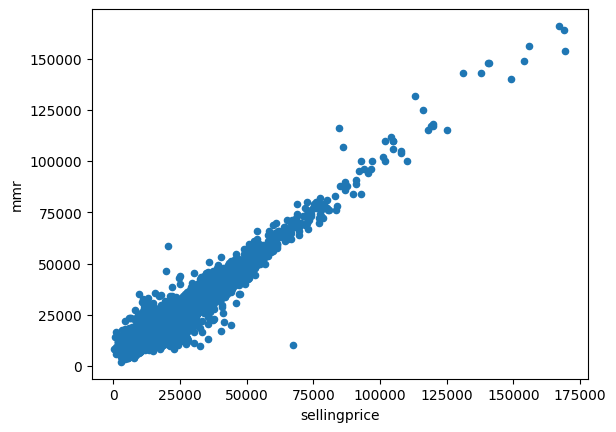

In [31]:
car_data.plot.scatter(x='sellingprice', y= 'mmr')
plt.show()

##### Relationship between sellingprice and condition

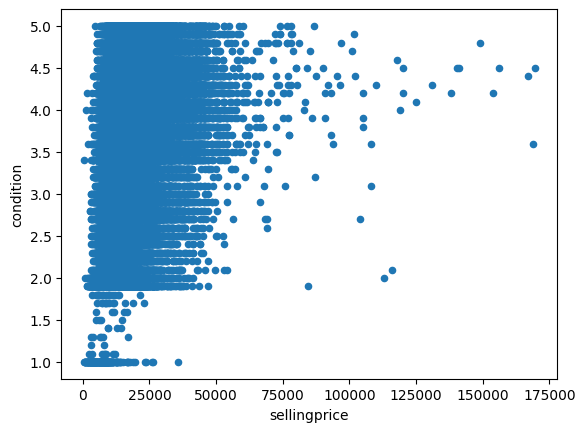

In [32]:
car_data.plot.scatter(x='sellingprice', y= 'condition')
plt.show()

##### Relationship between sellingprice and odometer

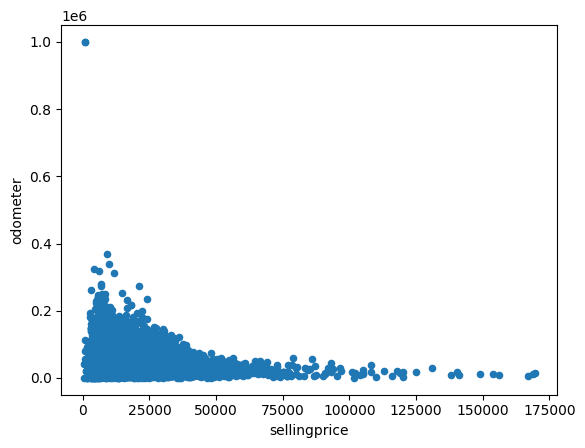

In [33]:
car_data.plot.scatter(x='sellingprice', y= 'odometer')
plt.show()

### Data Transformation

We can tranform the data to make it processable by the Machine Learning Algorithms

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

In [35]:
num_attribs = ['odometer', 'condition', 'mmr']
num_pipeline = make_pipeline(StandardScaler(),SimpleImputer(strategy="most_frequent"))

cat_attribs = ['make','model','trim',
               'body','transmission',
               'state',
               'color','interior',
               'seller','saledate']
cat_pipeline = make_pipeline(OrdinalEncoder())

In [36]:
for attribute in ['make','model','trim','body','transmission','state','color','interior','seller']:
    car_data[attribute] = car_data[attribute].str.lower() 

In [37]:
preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs)])

In [38]:
features_prepared = preprocessing.fit_transform(car_data)

In [39]:
features = pd.DataFrame(
    features_prepared, columns=preprocessing.get_feature_names_out(),
    index=car_data.index)

In [40]:
labels = pd.DataFrame(car_data[['sellingprice']])

In [41]:
features.describe() , labels.describe()

(       num__odometer  num__condition      num__mmr      cat__make  \
 count   1.006120e+05    1.006120e+05  1.006120e+05  100612.000000   
 mean   -8.474648e-18    7.796676e-16 -1.937870e-16      18.248281   
 std     1.000005e+00    1.000005e+00  1.000005e+00      10.285016   
 min    -1.899965e+00   -3.431532e+00 -1.842108e+00       0.000000   
 25%    -6.361230e-01   -6.155358e-01 -6.760869e-01      12.000000   
 50%    -2.257329e-01    1.524632e-01 -3.081980e-01      15.000000   
 75%     4.413073e-01    7.924623e-01  4.836985e-01      28.000000   
 max     4.279500e+01    1.688461e+00  1.861626e+01      38.000000   
 
           cat__model      cat__trim      cat__body  cat__transmission  \
 count  100612.000000  100612.000000  100612.000000      100612.000000   
 mean      126.429432     208.208782      22.292480           0.021359   
 std        84.145049     115.180915       6.431826           0.144580   
 min         0.000000       0.000000       0.000000           0.000000  

Lets have a look at the data

In [42]:
features.head()

,num__odometer,num__condition,num__mmr,cat__make,cat__model,cat__trim,cat__body,cat__transmission,cat__state,cat__color,cat__interior,cat__seller,cat__saledate
744,-0.607205,0.152463,3.963055,3.0,14.0,94.0,1.0,0.0,3.0,16.0,1.0,1457.0,8.0
745,0.027554,0.280463,-0.033840,0.0,273.0,106.0,24.0,0.0,3.0,1.0,1.0,86.0,8.0
746,-1.167860,1.176462,3.925642,3.0,14.0,94.0,1.0,0.0,3.0,7.0,1.0,1457.0,51.0
748,-0.266808,-0.231536,1.631013,1.0,20.0,61.0,24.0,0.0,3.0,18.0,0.0,1909.0,8.0
749,-0.338320,1.304462,3.227277,3.0,14.0,94.0,2.0,0.0,3.0,1.0,1.0,1457.0,8.0


### Upto this point, the Data Preprocessing is completed

=====================================================================================================================

### And now, we will start with Machine Learning

## Task 4:

#### Select  20%  of  the  data  for  testing.  Describe  how  you  did  that  and  verify  that  your  test portion of the data is representative of the entire dataset. 

To select 20% data for testing, we will use the train_test_split() method from sklearn.model_selection class, with test_size = 0.2. Here, 0.2 indicates 20% of total dataset. 

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Implemented Stratified Shuffle Split - Start

In [30]:
y = np.random.uniform(low=0.0, high=1.0, size=(len(labels),))

# bin the target variable into 5 categories
binned_labels = np.digitize(y, bins=[0.2, 0.4, 0.6, 0.8])

In [31]:
from sklearn.model_selection import train_test_split
phi_train, phi_test, t_train, t_test = train_test_split(features, labels, test_size=0.2, 
                                                        shuffle=True, 
                                                        random_state=42,
                                                        stratify=binned_labels
                                                       )

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Implemented Stratified Shuffle Split - End

In [43]:
# from sklearn.model_selection import train_test_split
# phi_train, phi_test, t_train, t_test = train_test_split(features, labels, test_size=0.2, shuffle=True, random_state=42)

In order to validate whether my train and test dataset have similar distribution, we will check the summary statistics of the both dataframes.

In [44]:
phi_train.describe()

,num__odometer,num__condition,num__mmr,cat__make,cat__model,cat__trim,cat__body,cat__transmission,cat__state,cat__color,cat__interior,cat__seller,cat__saledate
count,80489.000000,80489.000000,80489.000000,80489.000000,80489.000000,80489.000000,80489.000000,80489.000000,80489.000000,80489.000000,80489.000000,80489.000000,80489.000000
mean,-0.002648,-0.001313,0.002376,18.199555,126.533054,208.097790,22.272484,0.021270,16.592242,8.768701,3.462573,2321.739865,68.218303
std,0.988081,1.000839,1.001059,10.270991,84.134182,114.975793,6.444747,0.144284,11.444249,6.357344,3.971255,1279.950174,41.260522
min,-1.899965,-3.431532,-1.842108,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.636704,-0.615536,-0.676087,12.000000,46.000000,106.000000,24.000000,0.000000,5.000000,2.000000,1.000000,1518.000000,36.000000
50%,-0.224839,0.152463,-0.308198,15.000000,119.000000,219.000000,24.000000,0.000000,15.000000,7.000000,1.000000,2360.000000,55.000000
75%,0.438927,0.792462,0.496169,28.000000,195.000000,312.000000,26.000000,0.000000,28.000000,16.000000,6.000000,2942.000000,120.000000
max,42.795003,1.688461,18.616257,38.000000,304.000000,415.000000,30.000000,1.000000,37.000000,18.000000,16.000000,4489.000000,153.000000


In [45]:
phi_test.describe()

,num__odometer,num__condition,num__mmr,cat__make,cat__model,cat__trim,cat__body,cat__transmission,cat__state,cat__color,cat__interior,cat__seller,cat__saledate
count,20123.000000,20123.000000,20123.000000,20123.000000,20123.000000,20123.000000,20123.000000,20123.000000,20123.000000,20123.000000,20123.000000,20123.000000,20123.000000
mean,0.010592,0.005254,-0.009505,18.443174,126.014958,208.652736,22.372459,0.021716,16.592109,8.775729,3.500472,2321.456294,67.959946
std,1.046299,0.996669,0.995748,10.338885,84.189319,115.999558,6.379414,0.145760,11.397691,6.351266,3.961302,1277.698685,41.160569
min,-1.899965,-3.431532,-1.608280,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,-0.633978,-0.615536,-0.676087,12.000000,42.000000,106.000000,24.000000,0.000000,5.000000,2.000000,1.000000,1518.000000,36.000000
50%,-0.229309,0.152463,-0.320669,15.000000,119.000000,221.000000,24.000000,0.000000,15.000000,7.000000,1.000000,2360.000000,54.000000
75%,0.449654,0.792462,0.458757,28.000000,195.000000,312.000000,26.000000,0.000000,28.000000,16.000000,6.000000,2942.000000,120.000000
max,42.795003,1.688461,15.747971,38.000000,304.000000,414.000000,30.000000,1.000000,37.000000,18.000000,16.000000,4487.000000,152.000000


If we look at the data given by phi_train and phi_test, the median and the quartile ranges are almost similar. This means the both train and test datasets have almost the same distribution.

### ===================================================================================

# Task 5:

#### Train  a  Linear  Regression  model  using  the  training  data  with  four-fold  cross-validation using appropriate evaluation metric. Do this with closed form solution (using the Normal Equation or SVD) and with SGD. Perform Ridge, Lasso and Elastic Net regularization – try a  few  values  of  penalty  term  and  describe  its  impact.  Explore  the  impact  of  other hyperparameters,  like  batch  size  and  learning  rate  (no  need  for  grid  search).  Describe your findings. Display the training and validation loss as a function of training iterations. 

# Linear Regression 

In [46]:
from sklearn.model_selection import KFold, learning_curve, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [47]:
reg = LinearRegression().fit(phi_train, t_train)

reg_cv = cross_validate(reg, 
                        phi_train, 
                        t_train, 
                        scoring=['r2','neg_root_mean_squared_error','neg_mean_absolute_error'], 
                        cv=4, 
                        return_train_score=True)

In [48]:
# let's look at the output from k fold
def func_print_metrics( model_mame , model_cv ):
    print(model_mame+" : ")
    print("\n For metric R^2 :")
    print("\t Training loss: {:,.3f}".format(np.mean(model_cv['train_r2'])))
    print("\t Validation loss: {:,.3f}".format(np.mean(model_cv['test_r2'])))


    print("\n For metric Root mean Squared Error(RMSE) :")
    print("\t Training loss: {:,.3f}".format(-np.mean(model_cv['train_neg_root_mean_squared_error'])))
    print("\t Validation loss: {:,.3f}".format(-np.mean(model_cv['test_neg_root_mean_squared_error'])))


    print("\n For metric Mean Absolute Error(MAE) :")
    print("\t Training loss: {:,.3f}".format(-np.mean(model_cv['train_neg_mean_absolute_error'])))
    print("\t Validation loss: {:,.3f}".format(-np.mean(model_cv['test_neg_mean_absolute_error'])))

In [49]:
func_print_metrics("Linear Regression" , reg_cv )

Linear Regression : 

 For metric R^2 :
	 Training loss: 0.969
	 Validation loss: 0.969

 For metric Root mean Squared Error(RMSE) :
	 Training loss: 1,416.206
	 Validation loss: 1,416.699

 For metric Mean Absolute Error(MAE) :
	 Training loss: 945.014
	 Validation loss: 945.323


As we can see, there is not much gap between training loss and testing loss, when a cross validation method used with 3 parameters ${R^2}$, Root-Mean Squared Error, and Mean Absolute error. 

As the training and validation loss is equal, we might say that the model fits the data. However, the RMSE score is way too much higher, indicating this will not be the best fitting model for the given data.

#### Training and validation loss as a function of training set size

In [50]:
train_sizes, train_scores, valid_scores = learning_curve(reg, 
                                                         phi_train, 
                                                         t_train, 
                                                         train_sizes=np.linspace(0.1, 1.0,10), 
                                                         cv=4, 
                                                         scoring="neg_root_mean_squared_error")

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

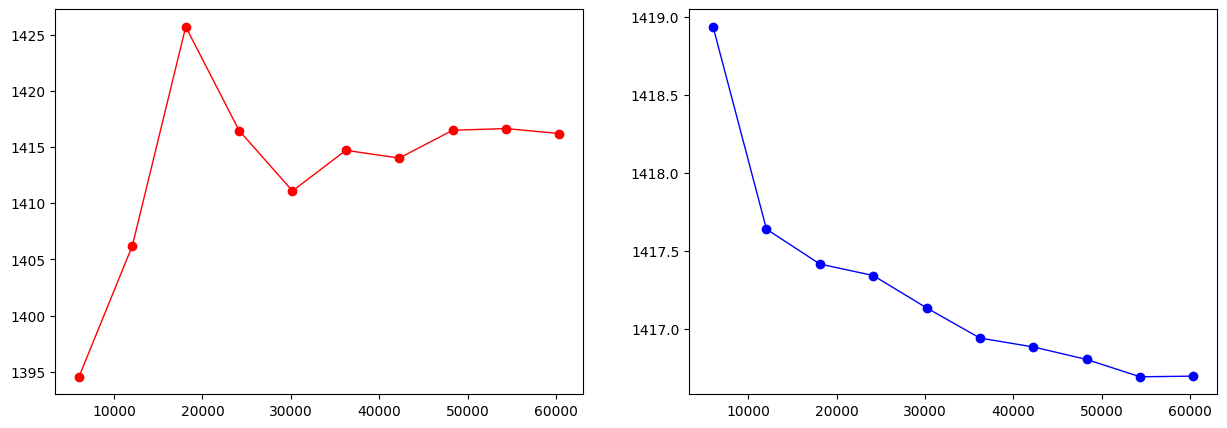

In [51]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(train_sizes, train_errors, "r-o", linewidth=1, label="train")
axes[1].plot(train_sizes, valid_errors, "b-o", linewidth=1, label="valid")
plt.show()

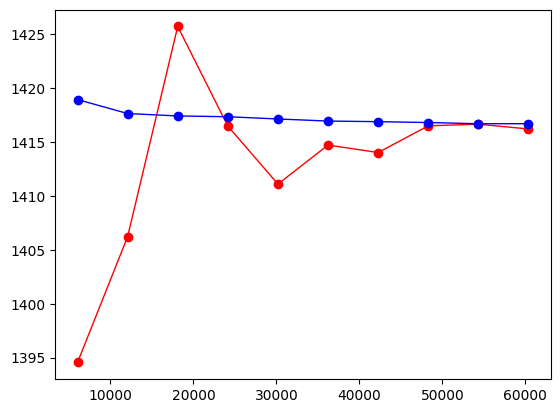

In [52]:
plt.plot(train_sizes, train_errors, "r-o", linewidth=1, label="train")
plt.plot(train_sizes, valid_errors, "b-o", linewidth=1, label="valid")
plt.show()

#### Observations : 
1. The above two figures depicts a line plot of Training loss and Validation Loss(RMSE) against different training set sizes.
2. The RMSE for training data steply fluctuating in the start and settling at the end in accordance with the training set sizes, whereas the validation loss gradually decreases, and it is catches with the training loss. This states that the model is overfitting for smaller portion of the data, i.e., including a bias, however for larger data the model settles.

##### ===============================================================================================================

# Stochastic Gradient Descent(SGD)

In [53]:
from sklearn.linear_model import SGDRegressor

In [54]:
sgd_reg = SGDRegressor(max_iter=1000, 
                       tol=1e-5, 
                       eta0=0.01, 
                       n_iter_no_change=100, 
                       random_state=42)

sgd_reg_cv = cross_validate(sgd_reg, 
                        phi_train, 
                        t_train, 
                        scoring=['r2','neg_root_mean_squared_error','neg_mean_absolute_error'], 
                        cv=4, 
                        return_train_score=True)

In [55]:
func_print_metrics("Stochastic Gradient Descent Regression" , sgd_reg_cv )

Stochastic Gradient Descent Regression : 

 For metric R^2 :
	 Training loss: -500,434,169,856,521,404,416.000
	 Validation loss: -495,984,261,387,765,743,616.000

 For metric Root mean Squared Error(RMSE) :
	 Training loss: 173,805,552,159,445.875
	 Validation loss: 173,896,495,011,869.281

 For metric Mean Absolute Error(MAE) :
	 Training loss: 151,606,549,602,591.469
	 Validation loss: 151,682,122,216,124.438


As we can see, there is huge between training loss and testing loss, when a cross validation method used with 3 parameters ${R^2}$, Root-Mean Squared Error, and Mean Absolute error. 

Also, the loss is soo huge that we will not select SGD model for this dataset

#### As the training and validation loss is way much higher there is no point in visualizing Training and validation loss as a function of training set size

##### ===============================================================================================================

# Linear Regression with Ridge Regularization

In [56]:
from sklearn.linear_model import Ridge

In [57]:
ridge_reg = Ridge(alpha=0.1, solver="cholesky")

ridge_reg.fit(phi_train, t_train)

ridge_reg_cv = cross_validate(ridge_reg, 
                        phi_train, 
                        t_train, 
                        scoring=['r2','neg_root_mean_squared_error','neg_mean_absolute_error'], 
                        cv=4, 
                        return_train_score=True)

In [58]:
func_print_metrics("Linear Regression with Ridge Regularization" , ridge_reg_cv )

Linear Regression with Ridge Regularization : 

 For metric R^2 :
	 Training loss: 0.969
	 Validation loss: 0.969

 For metric Root mean Squared Error(RMSE) :
	 Training loss: 1,416.206
	 Validation loss: 1,416.699

 For metric Mean Absolute Error(MAE) :
	 Training loss: 945.014
	 Validation loss: 945.323


As we can see, there is very little gap between training loss and testing loss, when a cross validation method used with 3 parameters ${R^2}$, Root-Mean Squared Error, and Mean Absolute error. 
Also, notably the loss values are similar to that of linear regression. 

#### Training and validation loss as a function of training set size

In [59]:
train_sizes, train_scores, valid_scores = learning_curve(ridge_reg, 
                                                         phi_train, 
                                                         t_train, 
                                                         train_sizes=np.linspace(0.1, 1.0, 10), 
                                                         cv=4, 
                                                         scoring="neg_root_mean_squared_error")

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

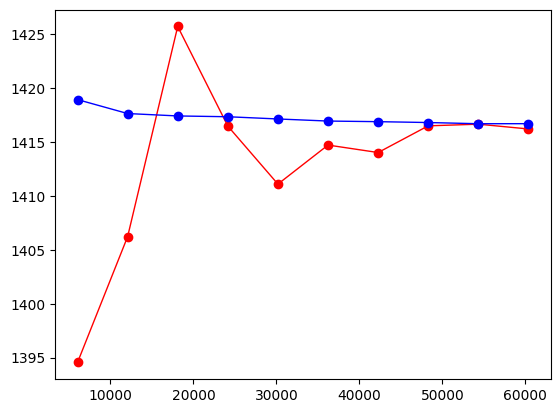

In [60]:
plt.plot(train_sizes, train_errors, "r-o", linewidth=1, label="train")
plt.plot(train_sizes, valid_errors, "b-o", linewidth=1, label="valid")

This plot is same as the linear regression

##### ===============================================================================================================

### Hyperparameter Tuning for Ridge Regression

In [61]:
from sklearn.linear_model import RidgeCV

In [62]:
ridge_cv = RidgeCV(alphas=np.arange(0.1,5,0.1)).fit(phi_train, t_train)
ridge_cv.score(phi_train, t_train)

0.969458106814872

In [63]:
ridge_cv.alpha_

1.3000000000000003

In [64]:
ridge_reg_training_loss = []
ridge_reg_validation_loss = []
for aplha_value in np.arange(0.1,5,0.1):
    ridge_reg = Ridge(alpha=aplha_value, solver="cholesky")
    ridge_reg_cv = cross_validate(ridge_reg, 
                                  phi_train, 
                                  t_train, 
                                  scoring='neg_root_mean_squared_error', 
                                  cv=4, 
                                  return_train_score=True)
    
    ridge_reg_training_loss.append(-np.mean(ridge_reg_cv['train_score']))
    ridge_reg_validation_loss.append(-np.mean(ridge_reg_cv['test_score']))

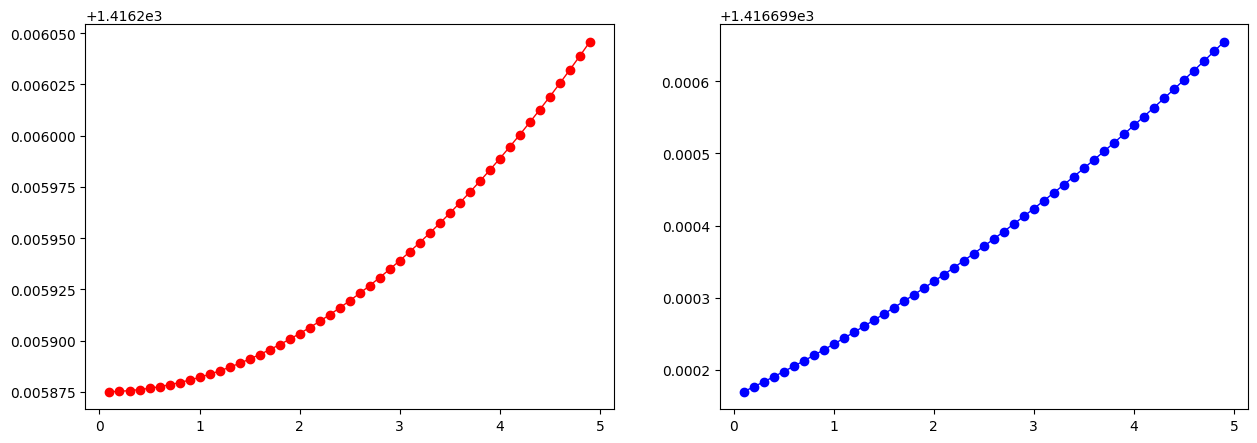

In [65]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(np.arange(0.1,5,0.1), ridge_reg_training_loss, "r-o", linewidth=1, label="train")
axes[1].plot(np.arange(0.1,5,0.1), ridge_reg_validation_loss, "b-o", linewidth=1, label="valid")
plt.show()

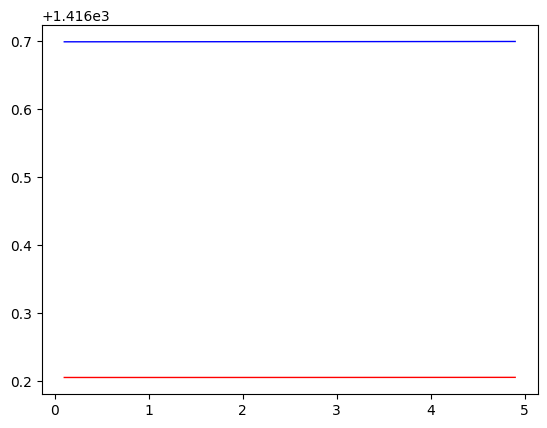

In [66]:
plt.plot(np.arange(0.1,5,0.1), ridge_reg_training_loss, "r-", linewidth=1, label="train")
plt.plot(np.arange(0.1,5,0.1), ridge_reg_validation_loss, "b-", linewidth=1, label="valid")

The above plot shows training and validation loss for Linear Regression with Ridge Regularization method, on X-axis denotes alpha values and Y axis denotes the loss.

Looking at the plot, we can infer that, the validation & training loss initially dips a bit and then gradually increases with increase in the value for alpha. Which indicates that, our model performs better at alpha = 1.3, value for alpha given by cross validation.

##### ===============================================================================================================

# Linear Regression with Lasso Regularization

In [67]:
from sklearn.linear_model import Lasso

In [68]:
lasso_reg = Lasso(alpha=0.1)

lasso_reg.fit(phi_train, t_train)

lasso_reg_cv = cross_validate(lasso_reg, 
                        phi_train, 
                        t_train, 
                        scoring=['r2','neg_root_mean_squared_error','neg_mean_absolute_error'], 
                        cv=4, 
                        return_train_score=True)

In [69]:
func_print_metrics("Linear Regression with Lasso Regularization" , lasso_reg_cv )

Linear Regression with Lasso Regularization : 

 For metric R^2 :
	 Training loss: 0.969
	 Validation loss: 0.969

 For metric Root mean Squared Error(RMSE) :
	 Training loss: 1,416.206
	 Validation loss: 1,416.699

 For metric Mean Absolute Error(MAE) :
	 Training loss: 945.010
	 Validation loss: 945.318


As we can see, there is very little gap between training loss and testing loss, when a cross validation method used with 3 parameters ${R^2}$, Root-Mean Squared Error, and Mean Absolute error. 

These values are similar as of the linear regression, and ridge regression with alpha = 0.1

#### Training and validation loss as a function of training set size

In [70]:
train_sizes, train_scores, valid_scores = learning_curve(lasso_reg, 
                                                         phi_train, 
                                                         t_train, 
                                                         train_sizes=np.linspace(0.1, 1.0, 10), 
                                                         cv=4, 
                                                         scoring="neg_root_mean_squared_error")

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

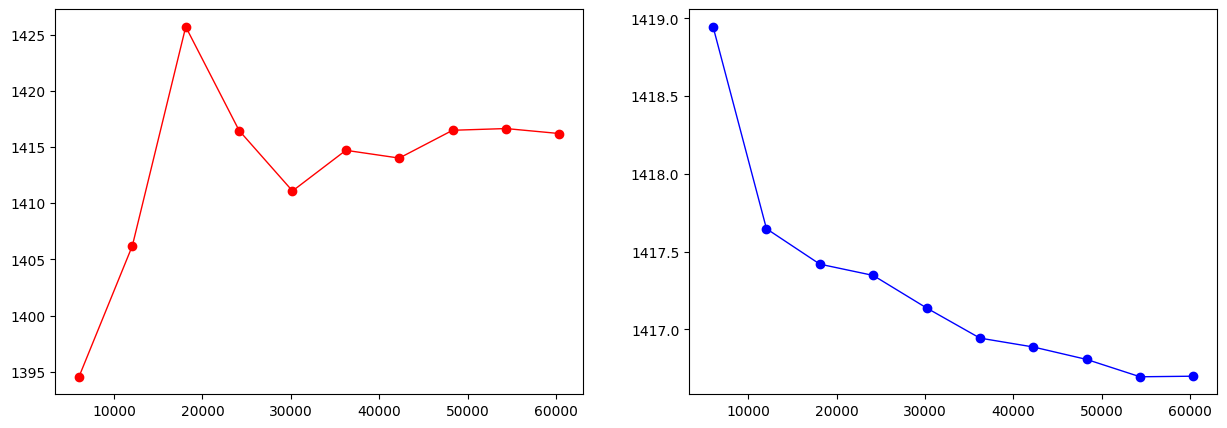

In [71]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(train_sizes, train_errors, "r-o", linewidth=1, label="train")
axes[1].plot(train_sizes, valid_errors, "b-o", linewidth=1, label="valid")

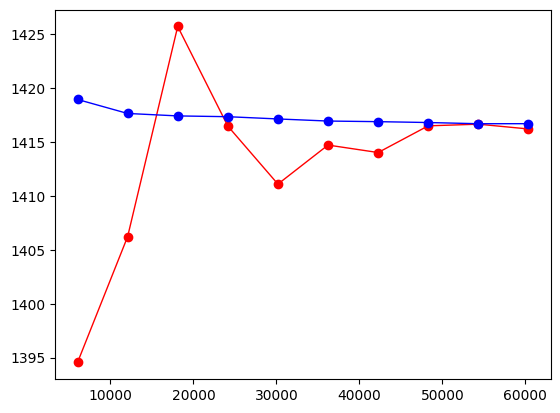

In [72]:
plt.plot(train_sizes, train_errors, "r-o", linewidth=1, label="train")
plt.plot(train_sizes, valid_errors, "b-o", linewidth=1, label="valid")

Again this plot is as similar as the liear regression and ridge regression

##### ===============================================================================================================

### Hyperparameter Tuning for Lasso Regression

In [73]:
from sklearn.linear_model import LassoCV

In [74]:
lasso_cv = LassoCV(alphas=np.arange(0.1,5,0.1)).fit(phi_train, t_train)
lasso_cv.score(phi_train, t_train)

0.9694580759289207

In [75]:
# The amount of penalization chosen by cross validation.
lasso_cv.alpha_

0.2

In [76]:
lasso_reg_training_loss = []
lasso_reg_validation_loss = []
for aplha_value in np.arange(0.1,5,0.1):
    lasso_reg = Lasso(alpha=aplha_value)
    lasso_reg_cv = cross_validate(lasso_reg, 
                                  phi_train, 
                                  t_train, 
                                  scoring='neg_root_mean_squared_error', 
                                  cv=4, 
                                  return_train_score=True)
    
    lasso_reg_training_loss.append(-np.mean(lasso_reg_cv['train_score']))
    lasso_reg_validation_loss.append(-np.mean(lasso_reg_cv['test_score']))

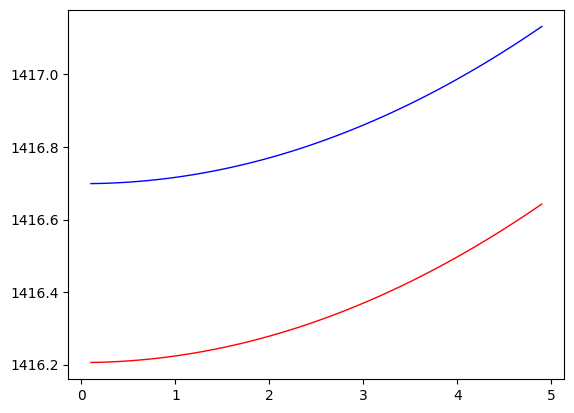

In [77]:
plt.plot(np.arange(0.1,5,0.1), lasso_reg_training_loss, "r-", linewidth=1, label="train")
plt.plot(np.arange(0.1,5,0.1), lasso_reg_validation_loss, "b-", linewidth=1, label="valid")

The above plot shows training and validation loss for Linear Regression with Lasso Regularization method, on X-axis denotes alpha values and Y axis denotes the loss.

Looking at the plot, we can infer that, there is slightly little dip at the begining and then the validation & training loss gradually increases. Which indicates that, our model performs better at alpha = 0.2, value for alpha given by cross validation.

##### ===============================================================================================================

# Linear Regression with Elastic Net Regularization

In [78]:
from sklearn.linear_model import ElasticNet

In [79]:
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)

elastic_net.fit(phi_train, t_train)

elastic_net_cv = cross_validate(elastic_net, 
                        phi_train, 
                        t_train, 
                        scoring=['r2','neg_root_mean_squared_error','neg_mean_absolute_error'], 
                        cv=4, 
                        return_train_score=True)

In [80]:
func_print_metrics("Linear Regression with Elastic Net Regularization" , elastic_net_cv )

Linear Regression with Elastic Net Regularization : 

 For metric R^2 :
	 Training loss: 0.967
	 Validation loss: 0.967

 For metric Root mean Squared Error(RMSE) :
	 Training loss: 1,469.929
	 Validation loss: 1,470.611

 For metric Mean Absolute Error(MAE) :
	 Training loss: 996.640
	 Validation loss: 996.912


As we can see, there is very little gap between training loss and testing loss, when a cross validation method used with 3 parameters ${R^2}$, Root-Mean Squared Error, and Mean Absolute error. 
And, again these values are similar as of the first 3 models.

#### Training and validation loss as a function of training set size

In [81]:
train_sizes, train_scores, valid_scores = learning_curve(elastic_net, 
                                                         phi_train, 
                                                         t_train, 
                                                         train_sizes=np.linspace(0.1, 1.0, 10), 
                                                         cv=4, 
                                                         scoring="neg_root_mean_squared_error")

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

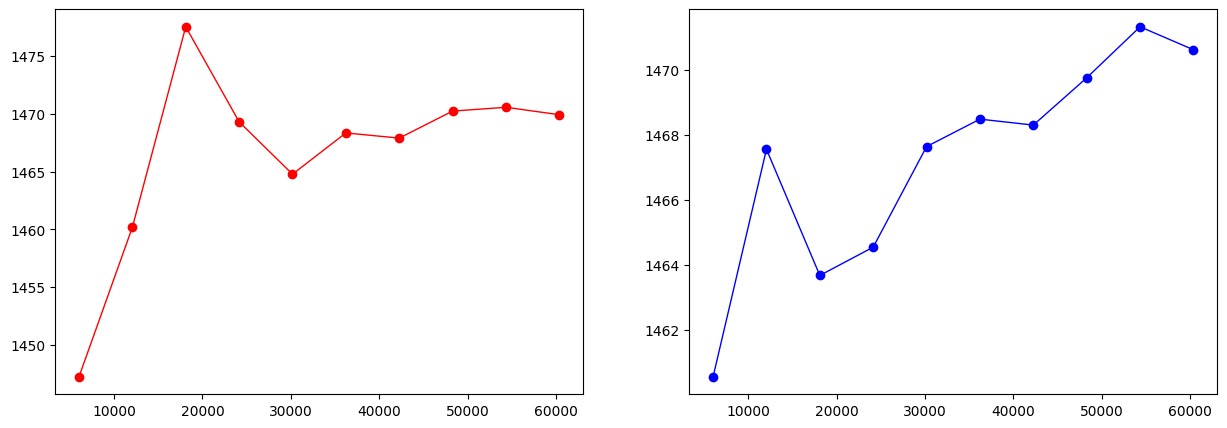

In [82]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(train_sizes, train_errors, "r-o", linewidth=1, label="train")
axes[1].plot(train_sizes, valid_errors, "b-o", linewidth=1, label="valid")

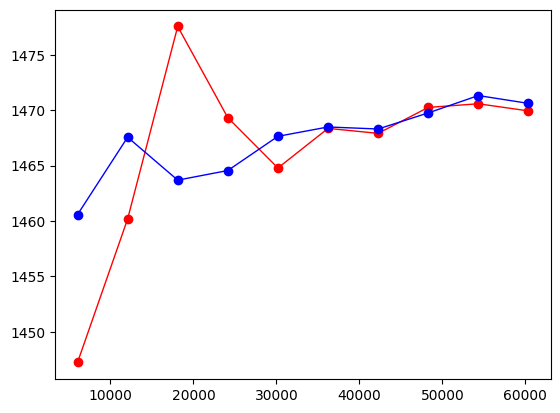

In [83]:
plt.plot(train_sizes, train_errors, "r-o", linewidth=1, label="train")
plt.plot(train_sizes, valid_errors, "b-o", linewidth=1, label="valid")

Thee Elastic Net regularization gives different learning curve than rest of the models. 
Noticable, the training loss and the validation loss overlaps each other at several places, indicating the model is underfitting the data.

##### ===============================================================================================================

### Hyperparameter Tuning for ElasticNet Regression

In [84]:
from sklearn.linear_model import ElasticNetCV

In [85]:
elastic_net_cv = ElasticNetCV(alphas=np.arange(0.1,5,0.1), l1_ratio=np.arange(0.0,1.1,0.1)).fit(phi_train, t_train)
elastic_net_cv.score(phi_train, t_train)

0.9694580759289207

In [86]:
elastic_net_cv.alpha_ , elastic_net_cv.l1_ratio_

(0.2, 1.0)

Training and validation loss as a function of training iterations. 

In [87]:
elastic_net_training_loss = []
elastic_net_validation_loss = []
for l1_ratio_value in np.arange(0.0,1.1,0.1):
    elastic_net = ElasticNet(alpha=0.01, l1_ratio=l1_ratio_value)
    elastic_net_cv = cross_validate(elastic_net, 
                                  phi_train, 
                                  t_train, 
                                  scoring='neg_root_mean_squared_error', 
                                  cv=4, 
                                  return_train_score=True)

    elastic_net_training_loss.append(-np.mean(elastic_net_cv['train_score']))
    elastic_net_validation_loss.append(-np.mean(elastic_net_cv['test_score']))

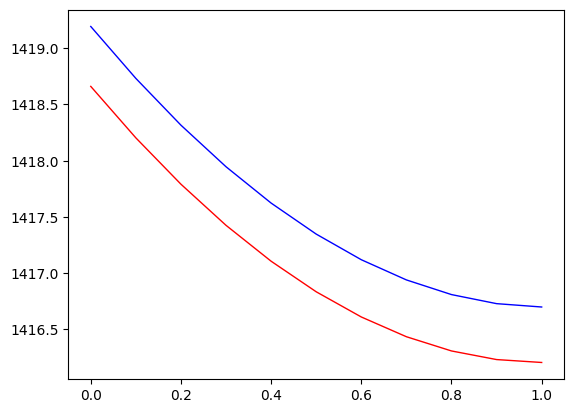

In [88]:
plt.plot(np.arange(0.0,1.1,0.1), elastic_net_training_loss, "r-", linewidth=1, label="train")
plt.plot(np.arange(0.0,1.1,0.1), elastic_net_validation_loss, "b-", linewidth=1, label="valid")

The above plot shows training and validation loss for Linear Regression with Lasso Regularization method, on X-axis denotes the L1 ratio values and Y axis denotes the loss.

Looking at the plot, we can infer that, the trainig and validation loss for the values of alpha is decreasing in sync with each other. In this model, we will choose l1 = 1.0 as the validation loss is minimum at this value. This means that the model functions better at l1 penalty, inturn making Lasso regularization superior over ridge for alpha =0.01

##### ===============================================================================================================

# Task 6 :

# Polynomial Regression

In [89]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)

In [90]:
poly_phi_train = poly_features.fit_transform(phi_train)
poly_phi_test = poly_features.fit_transform(phi_test)

In [91]:
poly_reg = LinearRegression().fit(poly_phi_train, t_train)

poly_reg_cv = cross_validate(poly_reg, 
                        poly_phi_train, 
                        t_train, 
                        scoring=['r2','neg_root_mean_squared_error','neg_mean_absolute_error'], 
                        cv=4, 
                        return_train_score=True)

In [92]:
func_print_metrics("Polynomial Regression" , poly_reg_cv )

Polynomial Regression : 

 For metric R^2 :
	 Training loss: 0.971
	 Validation loss: 0.970

 For metric Root mean Squared Error(RMSE) :
	 Training loss: 1,378.137
	 Validation loss: 1,411.897

 For metric Mean Absolute Error(MAE) :
	 Training loss: 915.854
	 Validation loss: 918.491


As we can see, there is huge gap between training loss and testing loss, when a cross validation method used with 3 parameters ${R^2}$, Root-Mean Squared Error, and Mean Absolute error. 

Even for the polynomial regression the RMSE values are high. So, I doubt there will be good predictables.

#### Training and validation loss as a function of training set size

In [93]:
train_sizes, train_scores, valid_scores = learning_curve(reg, 
                                                         poly_phi_train, 
                                                         t_train, 
                                                         train_sizes=np.linspace(0.1, 1.0,10), 
                                                         cv=4, 
                                                         scoring="neg_root_mean_squared_error")

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

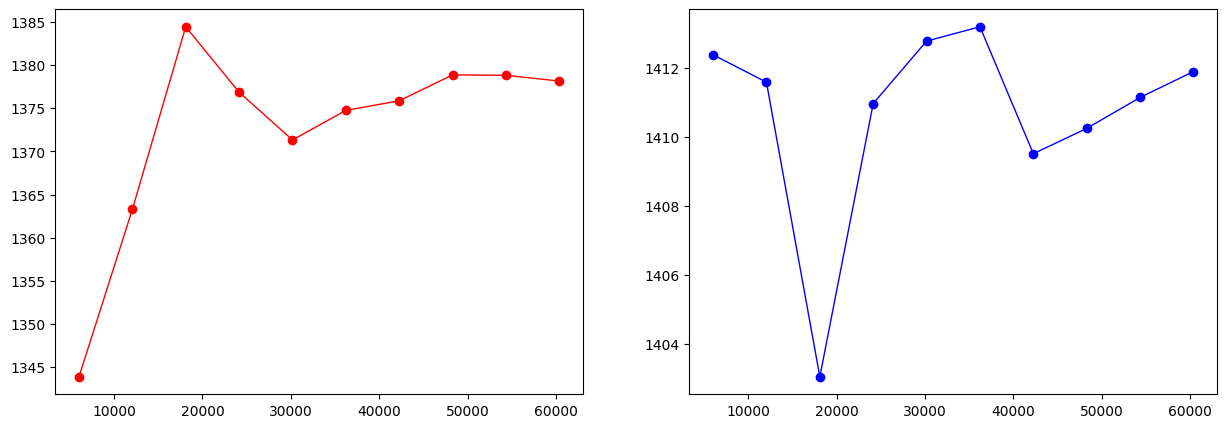

In [94]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(train_sizes, train_errors, "r-o", linewidth=1, label="train")
axes[1].plot(train_sizes, valid_errors, "b-o", linewidth=1, label="valid")
plt.show()

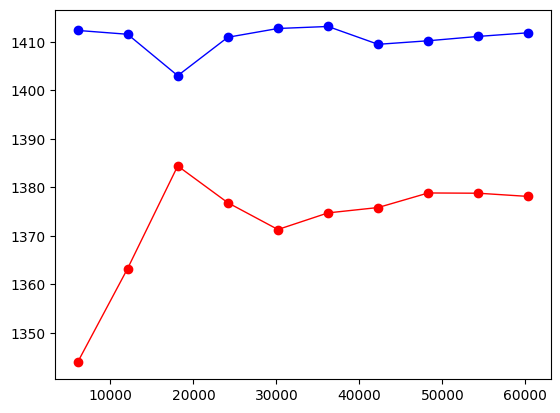

In [95]:
plt.plot(train_sizes, train_errors, "r-o", linewidth=1, label="train")
plt.plot(train_sizes, valid_errors, "b-o", linewidth=1, label="valid")
plt.show()

The above two figures depicts a line plot of Training loss and Validation Loss(RMSE) against different training set sizes.

The training loss is much lower than the validation loss, which indicaates that the model is overfitting on the data.

##### ======================================================================================================================

# Polynomial Regression Stochastic Gradient Descent 

In [96]:
sgd_reg = SGDRegressor(max_iter=1000, 
                       tol=1e-5, 
                       eta0=0.01, 
                       alpha = 0.01,
                       n_iter_no_change=100, 
                       random_state=42)

sgd_reg.fit(poly_phi_train, t_train)

sgd_reg_cv = cross_validate(sgd_reg, 
                        poly_phi_train, 
                        t_train, 
                        scoring=['r2','neg_root_mean_squared_error','neg_mean_absolute_error'], 
                        cv=4, 
                        return_train_score=True)

In [97]:
func_print_metrics("Polynomial Regression Stochastic Gradient Descent" , sgd_reg_cv )

Polynomial Regression Stochastic Gradient Descent : 

 For metric R^2 :
	 Training loss: -1,049,804,129,326,123,283,557,518,765,673,414,656.000
	 Validation loss: -971,903,846,288,483,448,267,841,541,364,514,816.000

 For metric Root mean Squared Error(RMSE) :
	 Training loss: 5,600,687,826,663,975,682,048.000
	 Validation loss: 5,575,384,309,074,754,535,424.000

 For metric Mean Absolute Error(MAE) :
	 Training loss: 4,250,423,473,909,095,989,248.000
	 Validation loss: 4,230,302,792,208,878,141,440.000


As we can see, there is very little gap between training loss and testing loss, when a cross validation method used with 3 parameters ${R^2}$, Root-Mean Squared Error, and Mean Absolute error. 

##### Similar to the linear regression, the training loss and is way much higer and thus we will reject this model.


# Polynomial Regression with Ridge Regularization

In [98]:
ridge_reg = Ridge(alpha=0.1, solver="cholesky")

ridge_reg.fit(poly_phi_train, t_train)

ridge_reg_cv = cross_validate(ridge_reg, 
                        poly_phi_train, 
                        t_train, 
                        scoring=['r2','neg_root_mean_squared_error','neg_mean_absolute_error'], 
                        cv=4, 
                        return_train_score=True)

In [99]:
func_print_metrics("Polynomial Regression with Ridge Regularization" , ridge_reg_cv )

Polynomial Regression with Ridge Regularization : 

 For metric R^2 :
	 Training loss: 0.971
	 Validation loss: 0.970

 For metric Root mean Squared Error(RMSE) :
	 Training loss: 1,378.137
	 Validation loss: 1,411.896

 For metric Mean Absolute Error(MAE) :
	 Training loss: 915.854
	 Validation loss: 918.491


As we can see, there is reasonably high gap between training loss and testing loss, when a cross validation method used with 3 parameters ${R^2}$, Root-Mean Squared Error, and Mean Absolute error.

Also, noticably, the loss is similar to that of simple polynomial regression. And the model is neither overfitting nor underfitting.

#### Training and validation loss as a function of training set size

In [100]:
train_sizes, train_scores, valid_scores = learning_curve(ridge_reg, 
                                                         poly_phi_train, 
                                                         t_train, 
                                                         train_sizes=np.linspace(0.1, 1.0, 10), 
                                                         cv=4, 
                                                         scoring="neg_root_mean_squared_error")

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

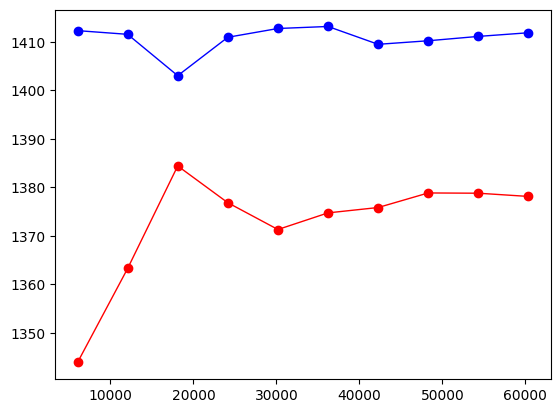

In [101]:
plt.plot(train_sizes, train_errors, "r-o", linewidth=1, label="train")
plt.plot(train_sizes, valid_errors, "b-o", linewidth=1, label="valid")

The above figures depicts a line plot of Training loss and Validation Loss(RMSE) against different training set sizes.

There is huge gap between training and validation loss, and the model overfits the data


##### ===============================================================================================================

### Hyperparameter Tuning for Ridge Regression

In [102]:
random_alpha_values = [0.01, 0.1, 1.7, 3.9, 12.0, 45.0, 100.0]

In [103]:
ridge_cv = RidgeCV(alphas=random_alpha_values).fit(poly_phi_train, t_train)
ridge_cv.score(poly_phi_train, t_train)

-23.9645093265131

In [104]:
ridge_cv.alpha_

45.0

In [105]:
poly_ridge_reg_training_loss = []
poly_ridge_reg_validation_loss = []
for aplha_value in random_alpha_values:
    poly_ridge_reg = Ridge(alpha=aplha_value, solver="cholesky")
    poly_ridge_reg_cv = cross_validate(poly_ridge_reg, 
                                  poly_phi_train, 
                                  t_train, 
                                  scoring='neg_root_mean_squared_error', 
                                  cv=4, 
                                  return_train_score=True)
    
    poly_ridge_reg_training_loss.append(-np.mean(poly_ridge_reg_cv['train_score']))
    poly_ridge_reg_validation_loss.append(-np.mean(poly_ridge_reg_cv['test_score']))

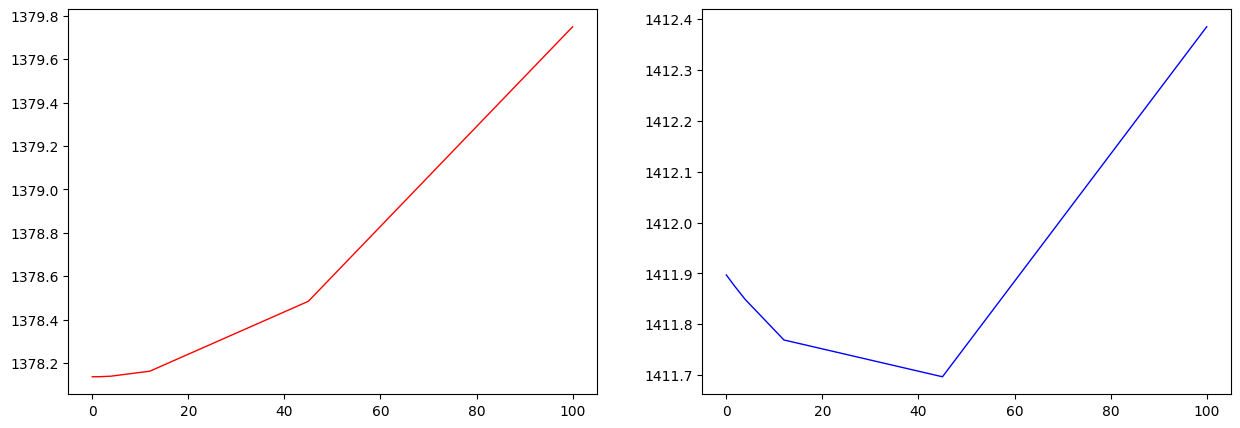

In [106]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(random_alpha_values, poly_ridge_reg_training_loss, "r-", linewidth=1, label="train")
axes[1].plot(random_alpha_values, poly_ridge_reg_validation_loss, "b-", linewidth=1, label="valid")
plt.show()

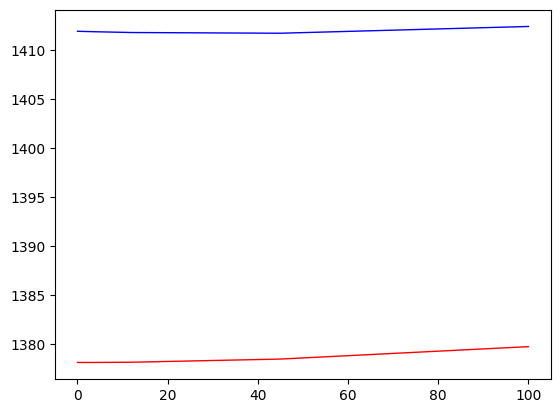

In [108]:
plt.plot(random_alpha_values, poly_ridge_reg_training_loss, "r-", linewidth=1, label="train")
plt.plot(random_alpha_values, poly_ridge_reg_validation_loss, "b-", linewidth=1, label="valid")

The above plot shows training and validation loss for Polynomial Regression with Ridge Regularization method, on X-axis denotes alpha values and Y axis denotes the loss.

Looking at the plot, we can infer that, the trainig loss for the values of alpha is increasing however the validation loss is decreasing. 
In this model, we will choose alpha = 45.0 as the validation loss is minimum at this value. This value is given by the cross validation function.

##### ===============================================================================================================

# Polynomial Regression with Lasso Regularization

In [109]:
lasso_reg = Lasso(alpha=0.1)

lasso_reg.fit(poly_phi_train, t_train)

lasso_reg_cv = cross_validate(lasso_reg, 
                        poly_phi_train, 
                        t_train, 
                        scoring=['r2','neg_root_mean_squared_error','neg_mean_absolute_error'], 
                        cv=4, 
                        return_train_score=True)

In [110]:
func_print_metrics("Polynomial Regression with Lasso Regularization" , lasso_reg_cv )

Polynomial Regression with Lasso Regularization : 

 For metric R^2 :
	 Training loss: 0.971
	 Validation loss: 0.970

 For metric Root mean Squared Error(RMSE) :
	 Training loss: 1,378.141
	 Validation loss: 1,411.764

 For metric Mean Absolute Error(MAE) :
	 Training loss: 915.835
	 Validation loss: 918.453


As we can see, there is reasonably high gap between training loss and testing loss, when a cross validation method used with 3 parameters ${R^2}$, Root-Mean Squared Error, and Mean Absolute error. 

These values are similar to the simple model and the ridge model.

#### Training and validation loss as a function of training set size

In [111]:
train_sizes, train_scores, valid_scores = learning_curve(lasso_reg, 
                                                         poly_phi_train, 
                                                         t_train, 
                                                         train_sizes=np.linspace(0.1, 1.0, 10), 
                                                         cv=4, 
                                                         scoring="neg_root_mean_squared_error")

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

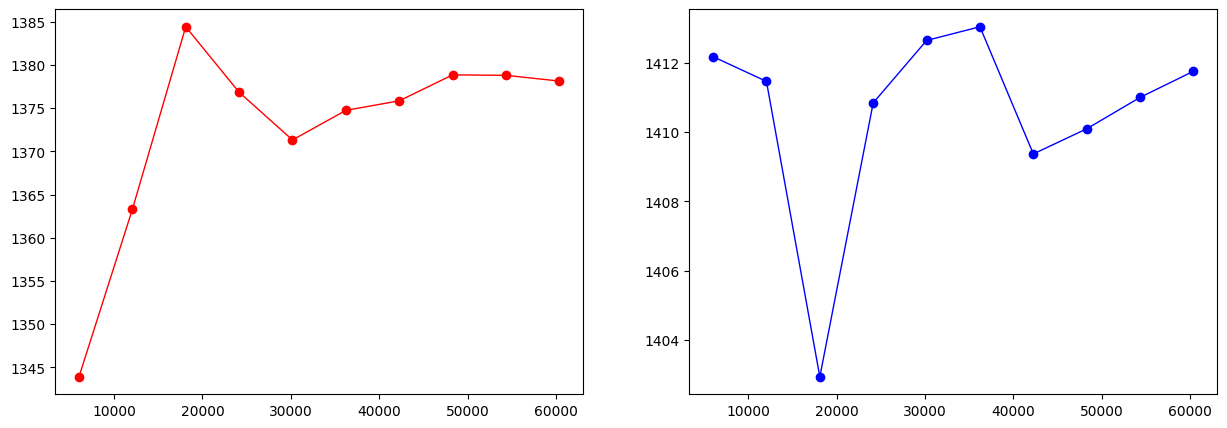

In [112]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(train_sizes, train_errors, "r-o", linewidth=1, label="train")
axes[1].plot(train_sizes, valid_errors, "b-o", linewidth=1, label="valid")

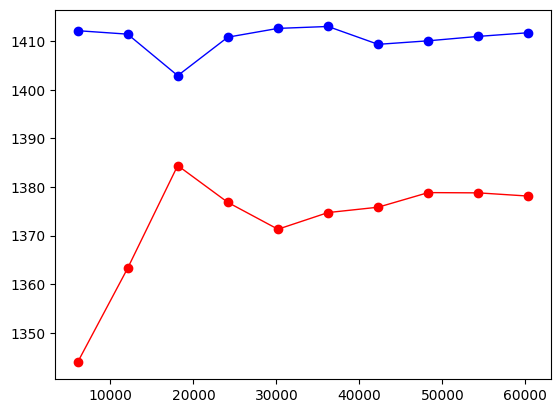

In [113]:
plt.plot(train_sizes, train_errors, "r-o", linewidth=1, label="train")
plt.plot(train_sizes, valid_errors, "b-o", linewidth=1, label="valid")

The above figures depicts a line plot of Training loss and Validation Loss(RMSE) against different training set sizes.

This learning curve looks kind of similar to learning curves given by simple polynomial and Ridge regularization models. Also, for this model, the validation loss is 

##### ===============================================================================================================

### Hyperparameter Tuning for Polynomial Regression with Lasso Regularization

In [114]:
random_alpha_values = [0.01, 0.1, 1.7, 3.9, 12.0, 45.0, 100.0]

In [115]:
lasso_cv = LassoCV(alphas=random_alpha_values).fit(poly_phi_train, t_train)
lasso_cv.score(poly_phi_train, t_train)

0.9709234651220853

In [116]:
# The amount of penalization chosen by cross validation.
lasso_cv.alpha_

12.0

In [117]:
poly_lasso_reg_training_loss = []
poly_lasso_reg_validation_loss = []
for aplha_value in random_alpha_values:
    poly_lasso_reg = Lasso(alpha=aplha_value)
    poly_lasso_reg_cv = cross_validate(poly_lasso_reg, 
                                  poly_phi_train, 
                                  t_train, 
                                  scoring='neg_root_mean_squared_error', 
                                  cv=4, 
                                  return_train_score=True)
    
    poly_lasso_reg_training_loss.append(-np.mean(poly_lasso_reg_cv['train_score']))
    poly_lasso_reg_validation_loss.append(-np.mean(poly_lasso_reg_cv['test_score']))

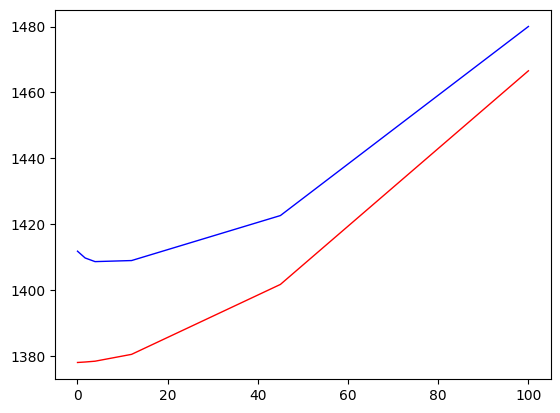

In [118]:
plt.plot(random_alpha_values, poly_lasso_reg_training_loss, "r-", linewidth=1, label="train")
plt.plot(random_alpha_values, poly_lasso_reg_validation_loss, "b-", linewidth=1, label="valid")

The above plot shows training and validation loss for Polynomial Regression with Lasso Regularization method, on X-axis denotes alpha values and Y axis denotes the loss.

Looking at the plot, we can infer that, the trainig and validation loss for the values of alpha is increasing in sync with each other. In this model, we will choose alpha = 12.0 as the validation loss is minimum at this value, and with higher values for alpha, the validation 

##### ===============================================================================================================

#  Polynomial Regression with Elastic Net Regularization

In [119]:
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)

elastic_net.fit(poly_phi_train, t_train)

elastic_net_cv = cross_validate(elastic_net, 
                        poly_phi_train, 
                        t_train, 
                        scoring=['r2','neg_root_mean_squared_error','neg_mean_absolute_error'], 
                        cv=4, 
                        return_train_score=True)

In [120]:
func_print_metrics("Polynomial Regression with Elastic Net  Regularization" , elastic_net_cv )

Polynomial Regression with Elastic Net  Regularization : 

 For metric R^2 :
	 Training loss: 0.961
	 Validation loss: 0.959

 For metric Root mean Squared Error(RMSE) :
	 Training loss: 1,604.758
	 Validation loss: 1,636.427

 For metric Mean Absolute Error(MAE) :
	 Training loss: 1,077.986
	 Validation loss: 1,080.991


As we can see, there is very little gap between training loss and testing loss, when a cross validation method used with 3 parameters ${R^2}$, Root-Mean Squared Error, and Mean Absolute error. 

The model for the loss ratio 0.5 and alpha = 0.1 performs better than the Lasso Regression but worse then ridge regression. And also here the training loss is higher than validation loss. Thus, the model is overfitting on training data.

#### Training and validation loss as a function of training set size

In [121]:
train_sizes, train_scores, valid_scores = learning_curve(elastic_net, 
                                                         poly_phi_train, 
                                                         t_train, 
                                                         train_sizes=np.linspace(0.1, 1.0, 10), 
                                                         cv=4, 
                                                         scoring="neg_root_mean_squared_error")

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

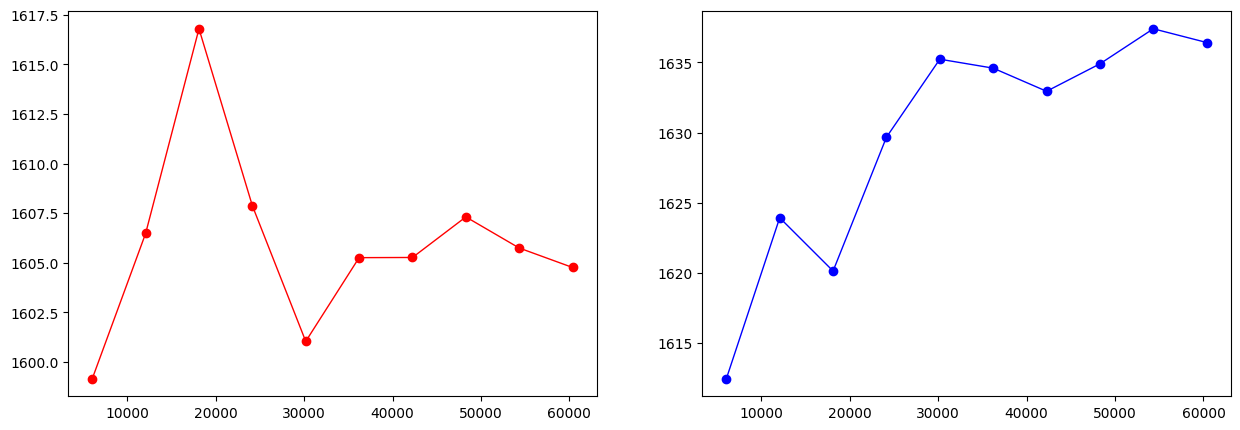

In [122]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(train_sizes, train_errors, "r-o", linewidth=1, label="train")
axes[1].plot(train_sizes, valid_errors, "b-o", linewidth=1, label="valid")
plt.show()

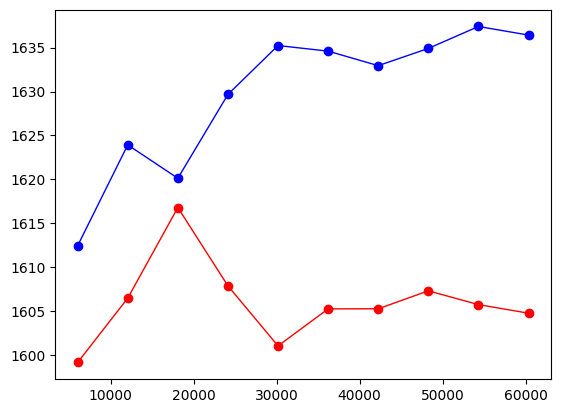

In [123]:
plt.plot(train_sizes, train_errors, "r-o", linewidth=1, label="train")
plt.plot(train_sizes, valid_errors, "b-o", linewidth=1, label="valid")
plt.show()

The above figures depicts a line plot of Training loss and Validation Loss(RMSE) against different training set sizes. This learning curve showing similar trends as of the linear regression with Lasso regularization, however the gap between both of them is relatively higher. Similar to the Lasso regularization, for this model, the validation loss is higher then the training loss. Thus, the model overfitts the data.

##### ===============================================================================================================

### Hyperparameter Tuning for  Polynomial  Regression with Elastic Net Regularization

In [125]:
elastic_net_cv = ElasticNetCV(alphas= random_alpha_values, l1_ratio=np.arange(0.0,1.1,0.1)).fit(poly_phi_train, t_train)
elastic_net_cv.score(poly_phi_train, t_train)

0.9709234651220853

In [126]:
elastic_net_cv.alpha_ , elastic_net_cv.l1_ratio_

(12.0, 1.0)

In [127]:
poly_elastic_net_training_loss = []
poly_elastic_net_validation_loss = []
for l1_ratio_value in np.arange(0.0,1.1,0.1):
    poly_elastic_net = ElasticNet(alpha=0.01, l1_ratio=l1_ratio_value)
    poly_elastic_net_cv = cross_validate(poly_elastic_net, 
                                  poly_phi_train, 
                                  t_train, 
                                  scoring='neg_root_mean_squared_error', 
                                  cv=4, 
                                  return_train_score=True)

    poly_elastic_net_training_loss.append(-np.mean(poly_elastic_net_cv['train_score']))
    poly_elastic_net_validation_loss.append(-np.mean(poly_elastic_net_cv['test_score']))

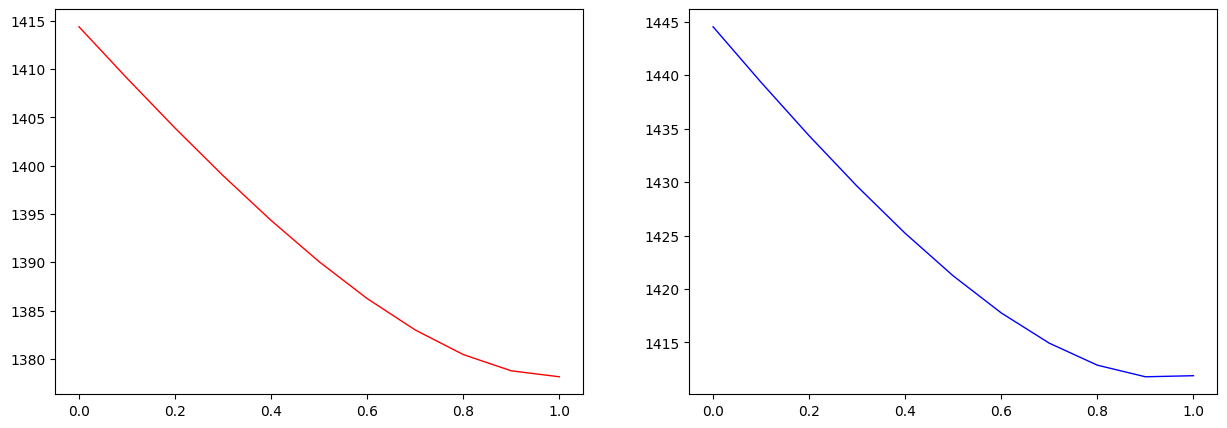

In [128]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(np.arange(0.0,1.1,0.1), poly_elastic_net_training_loss, "r-", linewidth=1, label="train")
axes[1].plot(np.arange(0.0,1.1,0.1), poly_elastic_net_validation_loss, "b-", linewidth=1, label="valid")
plt.show()

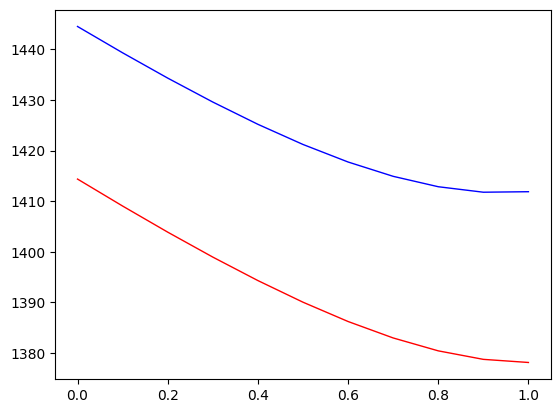

In [129]:
plt.plot(np.arange(0.0,1.1,0.1), poly_elastic_net_training_loss, "r-", linewidth=1, label="train")
plt.plot(np.arange(0.0,1.1,0.1), poly_elastic_net_validation_loss, "b-", linewidth=1, label="valid")

The above plot shows training and validation loss for Linear Regression with Lasso Regularization method, on X-axis denotes the L1 ratio values and Y axis denotes the loss.

Looking at the plot, we can infer that, the trainig and validation loss for the values of alpha is increasing in sync with each other. In this model, we will choose l1 = 1.0 as the validation loss is minimum at this value. This means that the model functions better at l2 penalty, inturn making Ridge regularization superior over Lasso for alpha=12.0

##### ===============================================================================================================

# Task 7:

## Make  predictions  of  the  labels  on  the  test  data,  using  the  trained  model  with  chosen hyperparameters. 

In this task, we will get the models and hyperparameters obtained by hyperparameter tuning for 5 linear regression models and 5 polynomial regression models.

### Model 1: Simple Linear Regression

In [130]:
reg = LinearRegression().fit(phi_train, t_train)
t_pred = reg.predict(phi_test)

In [131]:
# let's look at the output from k fold
print("Linear Regression: ")
print("\n R^2: {:,.3f}".format(r2_score(t_test, t_pred)))
print("\n Root mean Squared Error(RMSE) : {:,.3f}".format(np.sqrt(mean_squared_error(t_test, t_pred))))
print("\n Mean Absolute Error(MAE): {:,.3f}".format(mean_absolute_error(t_test, t_pred)))

Linear Regression: 

 R^2: 0.964

 Root mean Squared Error(RMSE) : 1,516.374

 Mean Absolute Error(MAE): 954.684


### Model 2 : Linear Regression with Stochastic Gradient Descent 

#### *I have rejected this model because of very high training and validation loss*

### Model 3: Linear Regression with Ridge Regularization

In [132]:
ridge_reg = Ridge(alpha=1.3, solver="cholesky")

ridge_reg.fit(phi_train, t_train)

t_pred = ridge_reg.predict(phi_test)

In [133]:
# let's look at the output from k fold
print("Linear Regression with Ridge Regularization: ")
print("\n R^2: {:,.3f}".format(r2_score(t_test, t_pred)))
print("\n Root mean Squared Error(RMSE) : {:,.3f}".format(np.sqrt(mean_squared_error(t_test, t_pred))))
print("\n Mean Absolute Error(MAE): {:,.3f}".format(mean_absolute_error(t_test, t_pred)))

Linear Regression with Ridge Regularization: 

 R^2: 0.964

 Root mean Squared Error(RMSE) : 1,516.368

 Mean Absolute Error(MAE): 954.685


### Model 4 : Linear Regression with Lasso Regularization 

In [134]:
lasso_reg = Lasso(alpha=0.2)

lasso_reg.fit(phi_train, t_train)

t_pred = lasso_reg.predict(phi_test)

In [135]:
# let's look at the output from k fold
print("Linear Regression with Lasso Regularization: ")
print("\n R^2: {:,.3f}".format(r2_score(t_test, t_pred)))
print("\n Root mean Squared Error(RMSE) : {:,.3f}".format(np.sqrt(mean_squared_error(t_test, t_pred))))
print("\n Mean Absolute Error(MAE): {:,.3f}".format(mean_absolute_error(t_test, t_pred)))

Linear Regression with Lasso Regularization: 

 R^2: 0.964

 Root mean Squared Error(RMSE) : 1,516.370

 Mean Absolute Error(MAE): 954.670


### Model 5: Linear Regression with Elastic Net Regularization 

In [136]:
elastic_net = ElasticNet(alpha=0.2, l1_ratio=1.0)

elastic_net.fit(phi_train, t_train)

t_pred = elastic_net.predict(phi_test)

In [137]:
# let's look at the output from k fold
print("Linear Regression with Elastic Net Regularization: ")
print("\n R^2: {:,.3f}".format(r2_score(t_test, t_pred)))
print("\n Root mean Squared Error(RMSE) : {:,.3f}".format(np.sqrt(mean_squared_error(t_test, t_pred))))
print("\n Mean Absolute Error(MAE): {:,.3f}".format(mean_absolute_error(t_test, t_pred)))

Linear Regression with Elastic Net Regularization: 

 R^2: 0.964

 Root mean Squared Error(RMSE) : 1,516.370

 Mean Absolute Error(MAE): 954.670


### Model 6: Simple Polynomial Regression

In [138]:
reg = LinearRegression().fit(poly_phi_train, t_train)

t_pred = reg.predict(poly_phi_test)

In [139]:
# let's look at the output from k fold
print("Simple Polynomial Regression: ")
print("\n R^2: {:,.3f}".format(r2_score(t_test, t_pred)))
print("\n Root mean Squared Error(RMSE) : {:,.3f}".format(np.sqrt(mean_squared_error(t_test, t_pred))))
print("\n Mean Absolute Error(MAE): {:,.3f}".format(mean_absolute_error(t_test, t_pred)))

Simple Polynomial Regression: 

 R^2: 0.966

 Root mean Squared Error(RMSE) : 1,480.138

 Mean Absolute Error(MAE): 924.017


### Model 7 : Polynomial Regression with Stochastic Gradient Descent 

#### *I have rejected this model because of very high training and validation loss*

### Model 8: Polynomial Regression with Ridge Regularization

In [140]:
ridge_reg = Ridge(alpha=45.0, solver="cholesky")

ridge_reg.fit(poly_phi_train, t_train)

t_pred = ridge_reg.predict(poly_phi_test)

In [141]:
# let's look at the output from k fold
print("Polynomial Regression with Ridge Regularization: ")
print("\n R^2: {:,.3f}".format(r2_score(t_test, t_pred)))
print("\n Root mean Squared Error(RMSE) : {:,.3f}".format(np.sqrt(mean_squared_error(t_test, t_pred))))
print("\n Mean Absolute Error(MAE): {:,.3f}".format(mean_absolute_error(t_test, t_pred)))

Polynomial Regression with Ridge Regularization: 

 R^2: 0.966

 Root mean Squared Error(RMSE) : 1,479.823

 Mean Absolute Error(MAE): 924.077


### Model 9 : Polynomial Regression with Lasso Regularization 

In [142]:
lasso_reg = Lasso(alpha=12.0)

lasso_reg.fit(poly_phi_train, t_train)

t_pred = lasso_reg.predict(poly_phi_test)

In [143]:
# let's look at the output from k fold
print("Polynomial Regression with Lasso Regularization: ")
print("\n R^2: {:,.3f}".format(r2_score(t_test, t_pred)))
print("\n Root mean Squared Error(RMSE) : {:,.3f}".format(np.sqrt(mean_squared_error(t_test, t_pred))))
print("\n Mean Absolute Error(MAE): {:,.3f}".format(mean_absolute_error(t_test, t_pred)))

Polynomial Regression with Lasso Regularization: 

 R^2: 0.966

 Root mean Squared Error(RMSE) : 1,480.492

 Mean Absolute Error(MAE): 924.910


### Model 10: Polynomial Regression with Elastic Net Regularization 

In [144]:
elastic_net = ElasticNet(alpha=12.0, l1_ratio=1.0)

elastic_net.fit(poly_phi_train, t_train)

t_pred = elastic_net.predict(poly_phi_test)

In [145]:
# let's look at the output from k fold
print("Polynomial Regression with Elastic Net Regularization: ")
print("\n R^2: {:,.3f}".format(r2_score(t_test, t_pred)))
print("\n Root mean Squared Error(RMSE) : {:,.3f}".format(np.sqrt(mean_squared_error(t_test, t_pred))))
print("\n Mean Absolute Error(MAE): {:,.3f}".format(mean_absolute_error(t_test, t_pred)))

Polynomial Regression with Elastic Net Regularization: 

 R^2: 0.966

 Root mean Squared Error(RMSE) : 1,480.492

 Mean Absolute Error(MAE): 924.910


### Conclusion: 
Out of all 10 models, the Polynomial Regression with Ridge Regularization has the least RMSE and the value of ${R^2}$ is close to 1. Thus, for this perticular dataset we will use Polynomial Regression with degree 2 using Ridge Regularization with alpha = 45.0.

### Improvements : 
1. I have tried only the polynomial degree 2, we can increase the polynomial degree and explore the better fitting model.
2. Also, for the learning rate, we selected range from (0.01, 2) with 0.01 step increase. This range can be further increased, say(0.0001, 10) with 0.0001 step increase
3. For polynomial regression, for learning rate I have selected some random values :0.01, 0.1, 1.7, 3.9, 12.0, 45.0, 100.0. This can be further improved by selecting continuous values from 0.001 to 50 with 0.001 step increse.
4. Also, in the data the RMSE values are high, this is possibly because there are outliers present in the data. So, outlier elimination methodologies needs to be inserted.

# Acknowledgement : 
I would like to thank my teammates Aoi and Avinash for their help. Also, I would like to thank Anshuman, for solving my doubts in TA session.

# References : 
 
[1] Geron, A. (2019). Hands-on machine learning with scikit-learn, keras, and TensorFlow: Concepts, tools, and techniques to build intelligent systems (2nd ed.). O’Reilly Media.

[2] API Reference. (n.d.). Scikit-learn. https://scikit-learn.org/stable/modules/classes.html

[3] API Reference. (n.d.). Pandas. https://pandas.pydata.org/docs/user_guide/index.html

[4] API Reference. (n.d.). NumPy. https://numpy.org/doc/stable/user/index.html#user